# Offensive Line EDA & Hypothesis Testing

What makes a prospect a pick? I've collected all this data but what will really matter when predicting a round a prospect will be picked in. I know I want to model based for each of the following position groups:

        * Quarterbacks (QBs)
        * Receivers & Running Backs (Receivers)
        * Offensive Line (OffensiveLine)
        * Linebackers (LBs)
        * Defensive Backs (DefensiveBacks)
        * Special Teams (SpecialTeams)
        
Before I start modeling, I want to check out my data and get to know what will matter when trying to nail down just which round a prospect will be selected in. I start by visualizing the distribution of my outcome in a given position group. From there I pass each variable I think I may want in my model.

In this notebook, I look into my Offensive Line data.

First things first, I need to load in my models.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import scipy.stats as stats
import scipy

import warnings
warnings.simplefilter('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# setting format for readability
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_pickle('cleaned_df')

In [4]:
df.head()

,PlayerName,Position,School,CombineYear,Height,Weight,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle,Draft Team,Round,Pick,Draft Year,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame,Feet,Inches,Pos
0,Shaun Alexander,RB,Alabama,2000,72,218,4.58,0.00,0.00,0.00,0.00,0.00,Seattle Seahawks,1st,19th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,11.00,302.00,1383.00,4.60,19.00,25.00,323.00,12.90,4.00,327.00,1706.00,5.20,23.00,27.45,125.73,1.73,2.27,29.36,0.36,29.73,155.09,2.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,24.00,0.00,0.00,144.00,0.00,2.18,0.00,0.00,13.09,72,0,Receivers
1,LaVar Arrington,OLB,Penn State,2000,75,250,4.53,0.00,0.00,0.00,0.00,0.00,Washington Redskins,1st,2nd pick,2000,12.00,0.00,0.00,0.00,0.00,0.00,1.00,27.00,27.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,2.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,3,LBs
2,John Baker,P,North Texas,2000,75,227,0.00,0.00,0.00,0.00,0.00,0.00,0,Not Drafted,Not Drafted,Not Drafted,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,1.00,1.00,100.00,27.00,27.00,27.00,0.00,0.00,326.80,0.09,0.09,2.45,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,3,SpecialTeams
3,Anthony Becht,TE,West Virginia,2000,78,270,4.78,33.50,0.00,123.00,6.94,4.08,New York Jets,1st,27th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0

## Functions

This is a lot of repetition so I build function to streamline the process over the 6 groups I need to investigate.

In [5]:
def position_family_df(position_family, df):
    """
    This funciton will filter for the specific position group - or family - I'm interested in for a 
    particular notebook. 
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        
    Returns:
        dataframe: filtered dataframe
        
    """
    dataframe = df[df['Pos'] == position_family]
    return dataframe

In [6]:
def plot_outcomes(position_family, df):
    """
    This function returns the count for each round a given position group has and graphs it. Along with the count,
    it will also print the normalized count -- % to total -- as a point of comparison.
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
    
    Returns:
        Dataframe shape, value counts for each round and the countplot for the distribution
        
    """
    dataframe = df
    print(position_family + ' Count: ')
    print('-'*40)
    print(position_family + ' Shape: ', dataframe.shape)
    print(dataframe['Round'].value_counts())
    print(round(dataframe['Round'].value_counts(normalize=True), 2))
    order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
    plt.figure(figsize=(10, 6))
    sns.countplot(dataframe['Round'],order=order, palette='bright');
    plt.title(position_family + ' Round Distribution')
    plt.savefig(position_family + '_round_distro')
    plt.show()

In [7]:
def plot_stats(position_family, df, lst):
    """
    The function returns the descriptive statistics for each item in a list. The list in question is a set of 
    feature I'm parsing through to determine if they're statistically significant. I want to first check their 
    distribution by plotting each feature's boxplot.
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        lst: feature list
        
    Returns:
        Prints descriptive statistics, mean by Round for the feature and plots the distribution boxplot.
    
    """
    for i in lst:
        dataframe = df
        order = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', 'Not Drafted']
        print(position_family + ' ' + i + ' Summary:')
        print(dataframe[i].describe())
        print('-' * 40)
        print(position_family + ' ' + i + ' by Round')
        print(dataframe[['Round', i]].groupby(['Round']).mean())
        plt.figure(figsize = (10,6))
        plt.title(position_family + ' ' + i + ' Distribution')
        sns.boxplot(y=dataframe[i], x=dataframe['Round'], order=order)
        plt.savefig(position_family + '_' + i + '_Distro')
        plt.show()

In [8]:
def anova_tukey(position_family, df, feature):
    """
    This function runs the ANOVA test checking for significance between a given feature and the output variable along
    with the 
    
    Parameters:
        position_family: string, value from 'Pos' column created in the data preprocessing notebook
        df: original dataframe that read in cleaned data
        feature: feature being tested  
        
    Returns:
        Prints ANOVA test summary and Tukey-MC analysis
    
    """
    dataframe = df
    anova_rounds = ols(feature + '~Round', data=dataframe).fit()
    anova_rounds
    anova_table = sm.stats.anova_lm(anova_rounds, type=2)
    print(anova_table)
    print('')
    mc = MultiComparison(dataframe[feature], dataframe['Round'])
    mc_results = mc.tukeyhsd()
    print(mc_results.summary())

## EDA & Hypothesis Testing

In [9]:
df = position_family_df('OffensiveLine', df)
df.head()

,PlayerName,Position,School,CombineYear,Height,Weight,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle,Draft Team,Round,Pick,Draft Year,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame,Feet,Inches,Pos
15,Cosey Coleman,OG,Tennessee,2000,76,322,5.40,28.00,0.00,101.00,8.15,4.97,Tampa Bay Buccaneers,2nd,51st pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,4,OffensiveLine
59,Stockar McDougle,OT,Oklahoma,2000,77,361,5.50,0.00,24.00,0.00,0.00,0.00,Detroit Lions,1st,20th pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,1.00,2.00,2.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,2.00,0.00,0.09,0.18,0.00,0.00,0.00,0.00,0.09,0.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,5,OffensiveLine
60,Chris McIntosh,OT,Wisconsin,2000,78,315,5.39,0.00,28.00,0.00,0.00,0.00,Seattle Seahawks,1st,22nd pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,72,6,OffensiveLine
79,Chris Samuels,OT,Alabama,2000,77,325,5.08,0.00,0.00,0.00,0.00,0.00,Washington Redskins,1st,3rd pick,2000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

Offensive Line Count: 
----------------------------------------
Offensive Line Shape:  (562, 121)
Not Drafted    127
1st             90
3rd             75
4th             68
2nd             65
5th             56
6th             43
7th             38
Name: Round, dtype: int64
Not Drafted   0.23
1st           0.16
3rd           0.13
4th           0.12
2nd           0.12
5th           0.10
6th           0.08
7th           0.07
Name: Round, dtype: float64


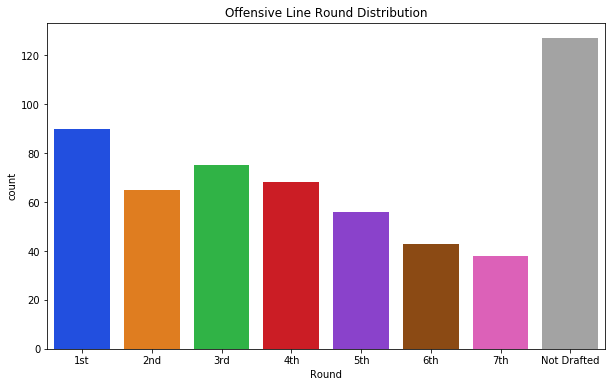

In [10]:
plot_outcomes('Offensive Line', df)

### Height & Weight

In [12]:
height_weight = ['Height', 'Weight']

Offensive Line Height Summary:
count   562.00
mean     76.65
std       1.47
min      73.00
25%      76.00
50%      77.00
75%      78.00
max      82.00
Name: Height, dtype: float64
----------------------------------------
Offensive Line Height by Round
             Height
Round              
1st           77.16
2nd           76.77
3rd           76.47
4th           76.54
5th           76.62
6th           76.19
7th           76.89
Not Drafted   76.47


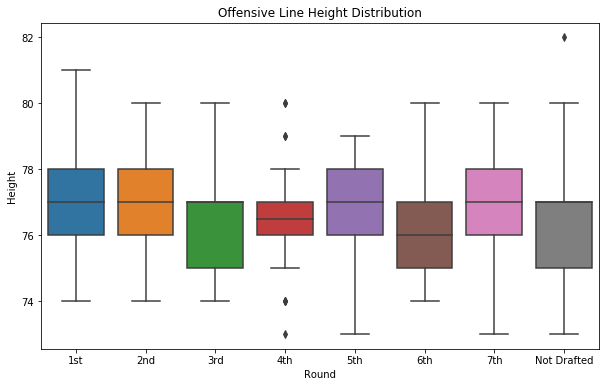

Offensive Line Weight Summary:
count   562.00
mean    312.79
std      12.72
min     273.00
25%     305.00
50%     310.00
75%     318.00
max     375.00
Name: Weight, dtype: float64
----------------------------------------
Offensive Line Weight by Round
             Weight
Round              
1st          316.91
2nd          311.52
3rd          313.56
4th          313.53
5th          313.50
6th          310.72
7th          313.89
Not Drafted  309.72


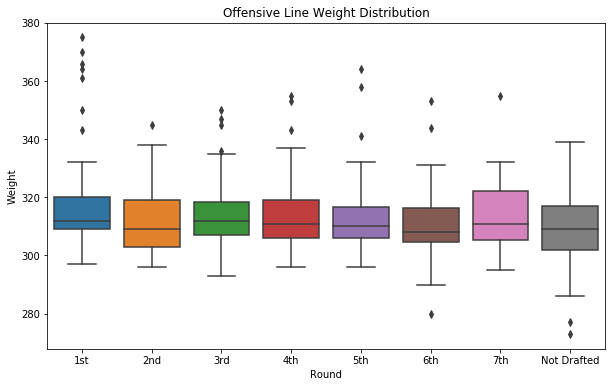

In [13]:
plot_stats('Offensive Line', df, height_weight)

In [14]:
anova_tukey('Offensive Line', df, 'Height')

             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   42.77     6.11 2.91    0.01
Residual 554.00 1163.76     2.10  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower   upper  reject
---------------------------------------------------------
   1st         2nd  -0.3863 0.7003 -1.1041  0.3315  False
   1st         3rd  -0.6889 0.0504 -1.3783  0.0006  False
   1st         4th  -0.6114 0.1488   -1.32  0.0971  False
   1st         5th  -0.5306 0.3855 -1.2811    0.22  False
   1st         6th  -0.9695  0.008  -1.787  -0.152   True
   1st         7th  -0.2608    0.9 -1.1139  0.5923  False
   1st Not Drafted  -0.6831 0.0154 -1.2907 -0.0755   True
   2nd         3rd  -0.3026    0.9 -1.0499  0.4447  False
   2nd         4th  -0.2251    0.9   -0.99  0.5398  False
   2nd         5th  -0.1442    0.9 -0.9482  0.6598  False
   2nd         6th  -0.5832 0.4535   -1.45  0.2836  False
   2nd         7th   0.1255    0.9  -0.775   1.02

In [15]:
anova_tukey('Offensive Line', df, 'Weight')

             df   sum_sq  mean_sq    F  PR(>F)
Round      7.00  3166.71   452.39 2.86    0.01
Residual 554.00 87548.51   158.03  nan     nan

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1    group2   meandiff p-adj   lower    upper  reject
----------------------------------------------------------
   1st         2nd   -5.388 0.1462 -11.6138  0.8377  False
   1st         3rd  -3.3511 0.6602   -9.331  2.6288  False
   1st         4th  -3.3817 0.6785  -9.5272  2.7638  False
   1st         5th  -3.4111 0.7261  -9.9208  3.0986  False
   1st         6th  -6.1902 0.1382 -13.2806  0.9002  False
   1st         7th  -3.0164    0.9 -10.4157   4.383  False
   1st Not Drafted  -7.1867  0.001 -12.4567 -1.9167   True
   2nd         3rd   2.0369    0.9  -4.4446  8.5185  False
   2nd         4th   2.0063    0.9  -4.6283   8.641  False
   2nd         5th   1.9769    0.9  -4.9965  8.9503  False
   2nd         6th  -0.8021    0.9  -8.3205  6.7162  False
   2nd         7th   2.3717    0

### Combine Stats

In [16]:
combine_columns = df[['_40yd', 'Vertical', 'Bench', 'BroadJump', '_3Cone', 'Shuttle']]
combine_columns.describe()

,_40yd,Vertical,Bench,BroadJump,_3Cone,Shuttle
count,562.00,562.00,562.00,562.00,562.00,562.00
mean,4.82,21.64,20.71,78.34,5.45,3.44
std,1.43,11.97,10.95,44.28,3.59,2.12
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,5.08,22.50,19.00,88.50,0.00,0.00
50%,5.22,26.50,23.00,100.00,7.61,4.64
75%,5.33,29.00,27.00,106.00,7.89,4.82
max,6.00,36.50,45.00,121.00,9.04,5.56


In [18]:
combine_stats = ['_40yd', 'Vertical', 'Bench', 'BroadJump', '_3Cone', 'Shuttle']

Offensive Line _40yd Summary:
count   562.00
mean      4.82
std       1.43
min       0.00
25%       5.08
50%       5.22
75%       5.33
max       6.00
Name: _40yd, dtype: float64
----------------------------------------
Offensive Line _40yd by Round
             _40yd
Round             
1st           4.81
2nd           4.84
3rd           4.95
4th           4.87
5th           5.06
6th           4.66
7th           5.27
Not Drafted   4.51


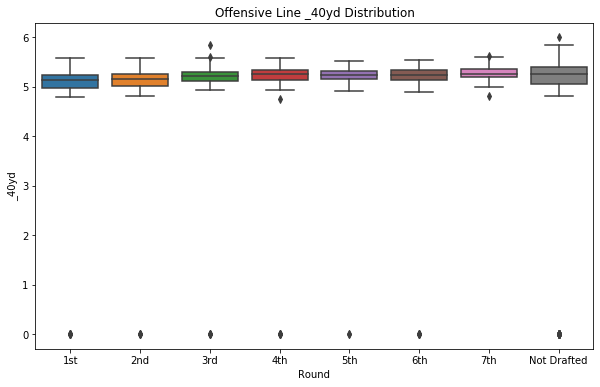

Offensive Line Vertical Summary:
count   562.00
mean     21.64
std      11.97
min       0.00
25%      22.50
50%      26.50
75%      29.00
max      36.50
Name: Vertical, dtype: float64
----------------------------------------
Offensive Line Vertical by Round
             Vertical
Round                
1st             21.94
2nd             25.71
3rd             18.82
4th             21.60
5th             23.95
6th             21.78
7th             22.22
Not Drafted     19.79


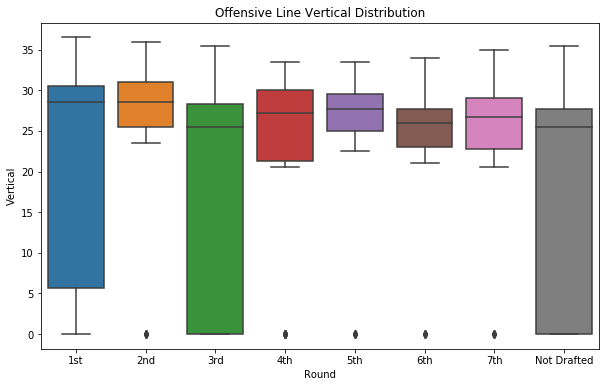

Offensive Line Bench Summary:
count   562.00
mean     20.71
std      10.95
min       0.00
25%      19.00
50%      23.00
75%      27.00
max      45.00
Name: Bench, dtype: float64
----------------------------------------
Offensive Line Bench by Round
             Bench
Round             
1st          21.77
2nd          22.85
3rd          20.01
4th          20.65
5th          21.41
6th          21.72
7th          20.45
Not Drafted  18.76


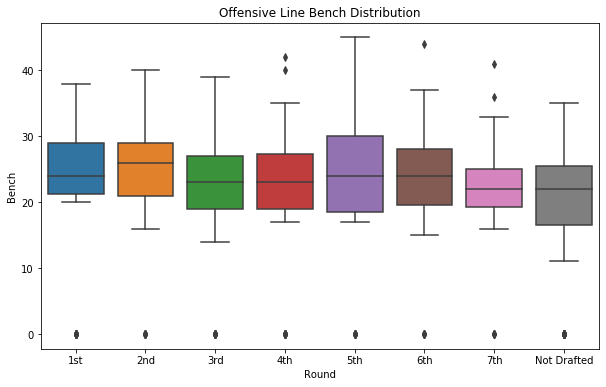

Offensive Line BroadJump Summary:
count   562.00
mean     78.34
std      44.28
min       0.00
25%      88.50
50%     100.00
75%     106.00
max     121.00
Name: BroadJump, dtype: float64
----------------------------------------
Offensive Line BroadJump by Round
             BroadJump
Round                 
1st              78.62
2nd              87.58
3rd              69.76
4th              80.25
5th              83.61
6th              79.33
7th              84.00
Not Drafted      73.09


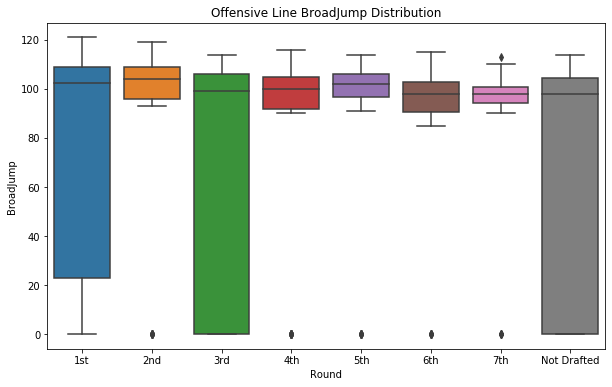

Offensive Line _3Cone Summary:
count   562.00
mean      5.45
std       3.59
min       0.00
25%       0.00
50%       7.61
75%       7.89
max       9.04
Name: _3Cone, dtype: float64
----------------------------------------
Offensive Line _3Cone by Round
             _3Cone
Round              
1st            5.14
2nd            6.17
3rd            5.01
4th            5.42
5th            6.14
6th            5.80
7th            5.92
Not Drafted    5.03


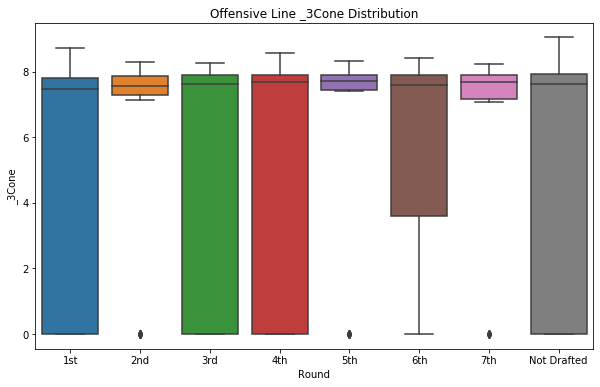

Offensive Line Shuttle Summary:
count   562.00
mean      3.44
std       2.12
min       0.00
25%       0.00
50%       4.64
75%       4.82
max       5.56
Name: Shuttle, dtype: float64
----------------------------------------
Offensive Line Shuttle by Round
             Shuttle
Round               
1st             3.28
2nd             3.93
3rd             3.04
4th             3.43
5th             3.83
6th             3.75
7th             3.61
Not Drafted     3.22


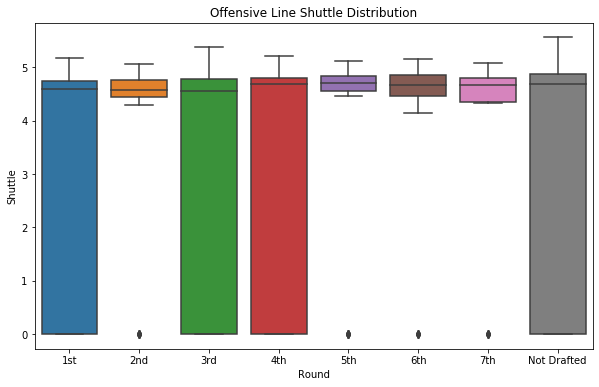

In [19]:
plot_stats('Offensive Line', df, combine_stats)

In [20]:
for i in combine_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Offensive Line', df, i)
    print('')
    print('*' * 60)

_40yd ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   25.59     3.66 1.80    0.09
Residual 554.00 1125.92     2.03  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0274    0.9 -0.6787 0.7334  False
   1st         3rd   0.1434    0.9 -0.5347 0.8216  False
   1st         4th   0.0582    0.9 -0.6388 0.7551  False
   1st         5th   0.2466    0.9 -0.4917 0.9848  False
   1st         6th  -0.1513    0.9 -0.9554 0.6527  False
   1st         7th   0.4602 0.6818 -0.3789 1.2993  False
   1st Not Drafted   -0.299 0.7691 -0.8966 0.2987  False
   2nd         3rd   0.1161    0.9  -0.619 0.8511  False
   2nd         4th   0.0308    0.9 -0.7216 0.7832  False
   2nd         5th   0.2192    0.9 -0.5716   1.01  False
   2nd         6th  -0.1787    0.9 -1.0313 0.6739  False
   2

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   1.0281 0.6251 -0.7452 2.8015  False
   1st         3rd  -0.1336    0.9  -1.837 1.5697  False
   1st         4th   0.2792    0.9 -1.4713 2.0297  False
   1st         5th   0.9975 0.7009 -0.8568 2.8517  False
   1st         6th   0.6554    0.9 -1.3643 2.6751  False
   1st         7th   0.7826    0.9 -1.3251 2.8902  False
   1st Not Drafted  -0.1073    0.9 -1.6085 1.3938  False
   2nd         3rd  -1.1618 0.5354  -3.008 0.6845  False
   2nd         4th  -0.7489    0.9 -2.6388 1.1409  False
   2nd         5th  -0.0307    0.9  -2.017 1.9557  False
   2nd         6th  -0.3727    0.9 -2.5143 1.7688  False
   2nd         7th  -0.2455    0.9 -2.4703 1.9792  False
   2nd Not Drafted  -1.1355 0.4324  -2.797 0.5261  False
   3rd         4th   0.4128    0.9 -1.4115 2.2371  False
   3rd         5th   1.1311 0.6

### College Stats - Passing

In [21]:
passing_stats = ['Passing_Games', 'Completions', 'Pass_Attempts', 'Completion_Percent', 'Pass_Yards', 
                 'Pass_Yds_per_Attempt', 'Adj_Pass_Yds_per_Attempt', 'Pass_TDs', 'Pass_Interceptions', 'Passer_Rating', 
                 'CompletionsperGame', 'Pass_AttemptsperGame', 'Pass_YardsperGame', 'Pass_TDsperGame', 
                 'Pass_InterceptionsperGame']

In [22]:
df[passing_stats].describe()

,Passing_Games,Completions,Pass_Attempts,Completion_Percent,Pass_Yards,Pass_Yds_per_Attempt,Adj_Pass_Yds_per_Attempt,Pass_TDs,Pass_Interceptions,Passer_Rating,CompletionsperGame,Pass_AttemptsperGame,Pass_YardsperGame,Pass_TDsperGame,Pass_InterceptionsperGame
count,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00
mean,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.69,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,12.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00


Offensive Line Passing_Games Summary:
count   562.00
mean      0.04
std       0.69
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      12.00
Name: Passing_Games, dtype: float64
----------------------------------------
Offensive Line Passing_Games by Round
             Passing_Games
Round                     
1st                   0.13
2nd                   0.02
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.09


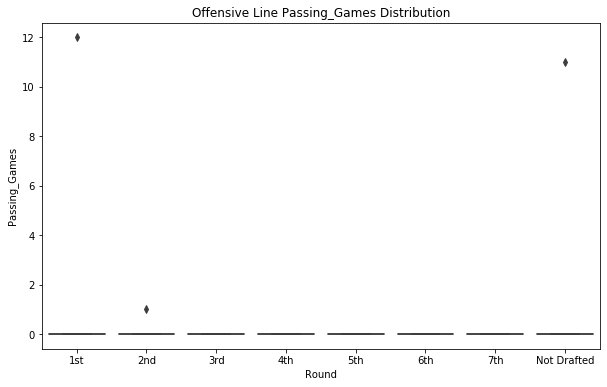

Offensive Line Completions Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Completions, dtype: float64
----------------------------------------
Offensive Line Completions by Round
             Completions
Round                   
1st                 0.00
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.00


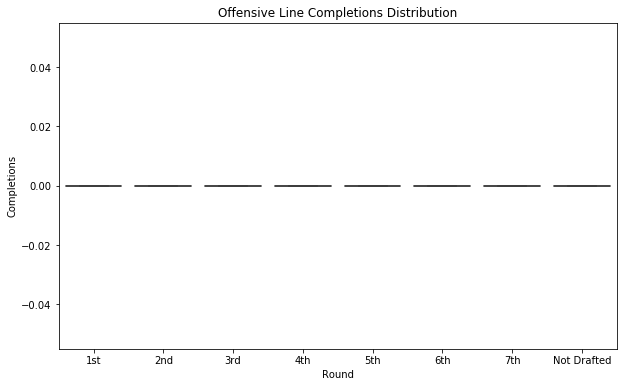

Offensive Line Pass_Attempts Summary:
count   562.00
mean      0.00
std       0.04
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Pass_Attempts, dtype: float64
----------------------------------------
Offensive Line Pass_Attempts by Round
             Pass_Attempts
Round                     
1st                   0.01
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


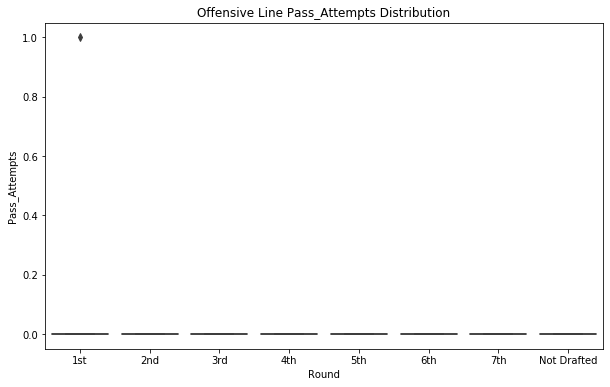

Offensive Line Completion_Percent Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Completion_Percent, dtype: float64
----------------------------------------
Offensive Line Completion_Percent by Round
             Completion_Percent
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


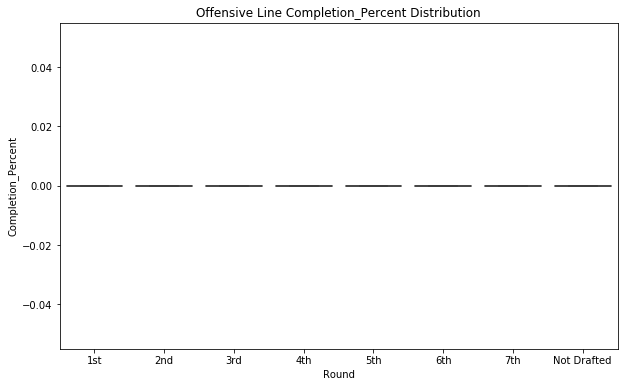

Offensive Line Pass_Yards Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pass_Yards, dtype: float64
----------------------------------------
Offensive Line Pass_Yards by Round
             Pass_Yards
Round                  
1st                0.00
2nd                0.00
3rd                0.00
4th                0.00
5th                0.00
6th                0.00
7th                0.00
Not Drafted        0.00


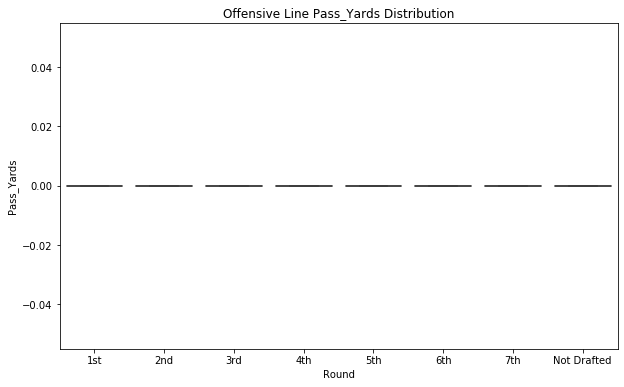

Offensive Line Pass_Yds_per_Attempt Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pass_Yds_per_Attempt, dtype: float64
----------------------------------------
Offensive Line Pass_Yds_per_Attempt by Round
             Pass_Yds_per_Attempt
Round                            
1st                          0.00
2nd                          0.00
3rd                          0.00
4th                          0.00
5th                          0.00
6th                          0.00
7th                          0.00
Not Drafted                  0.00


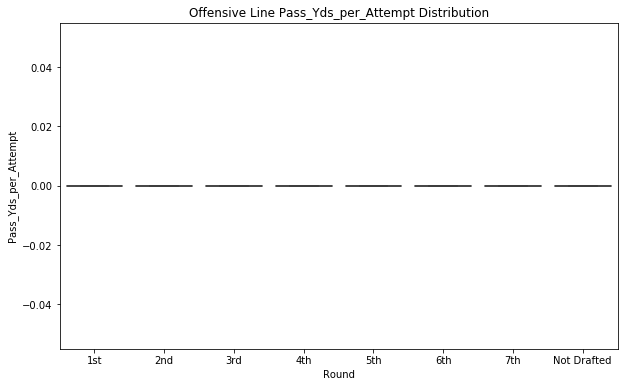

Offensive Line Adj_Pass_Yds_per_Attempt Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Adj_Pass_Yds_per_Attempt, dtype: float64
----------------------------------------
Offensive Line Adj_Pass_Yds_per_Attempt by Round
             Adj_Pass_Yds_per_Attempt
Round                                
1st                              0.00
2nd                              0.00
3rd                              0.00
4th                              0.00
5th                              0.00
6th                              0.00
7th                              0.00
Not Drafted                      0.00


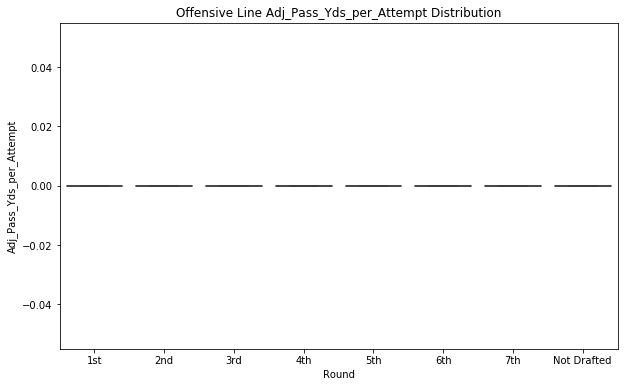

Offensive Line Pass_TDs Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pass_TDs, dtype: float64
----------------------------------------
Offensive Line Pass_TDs by Round
             Pass_TDs
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.00


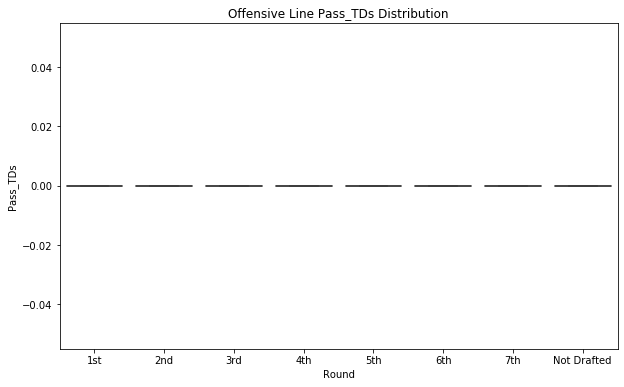

Offensive Line Pass_Interceptions Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pass_Interceptions, dtype: float64
----------------------------------------
Offensive Line Pass_Interceptions by Round
             Pass_Interceptions
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


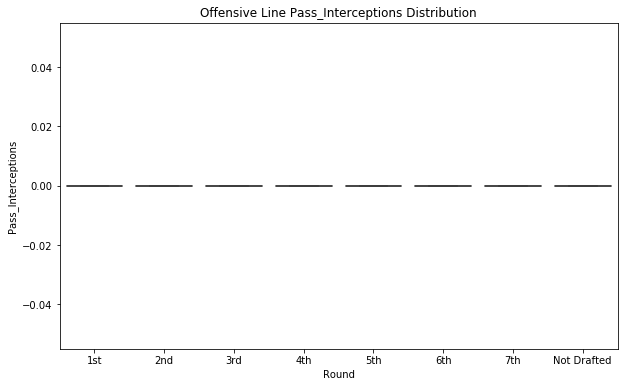

Offensive Line Passer_Rating Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Passer_Rating, dtype: float64
----------------------------------------
Offensive Line Passer_Rating by Round
             Passer_Rating
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


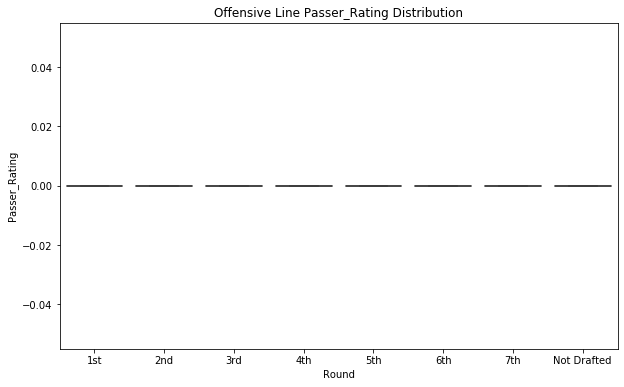

Offensive Line CompletionsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: CompletionsperGame, dtype: float64
----------------------------------------
Offensive Line CompletionsperGame by Round
             CompletionsperGame
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


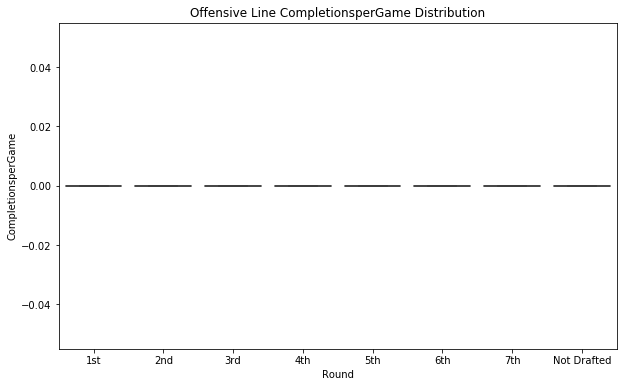

Offensive Line Pass_AttemptsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.08
Name: Pass_AttemptsperGame, dtype: float64
----------------------------------------
Offensive Line Pass_AttemptsperGame by Round
             Pass_AttemptsperGame
Round                            
1st                          0.00
2nd                          0.00
3rd                          0.00
4th                          0.00
5th                          0.00
6th                          0.00
7th                          0.00
Not Drafted                  0.00


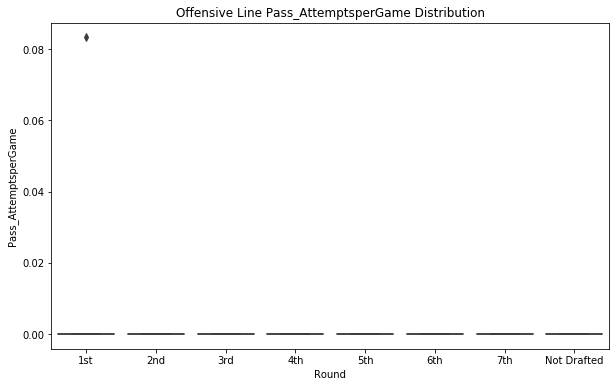

Offensive Line Pass_YardsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pass_YardsperGame, dtype: float64
----------------------------------------
Offensive Line Pass_YardsperGame by Round
             Pass_YardsperGame
Round                         
1st                       0.00
2nd                       0.00
3rd                       0.00
4th                       0.00
5th                       0.00
6th                       0.00
7th                       0.00
Not Drafted               0.00


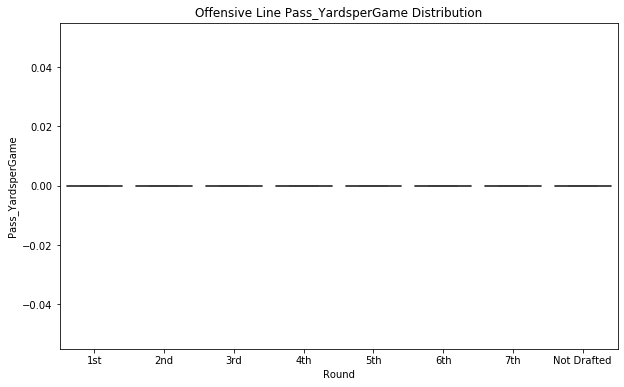

Offensive Line Pass_TDsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pass_TDsperGame, dtype: float64
----------------------------------------
Offensive Line Pass_TDsperGame by Round
             Pass_TDsperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


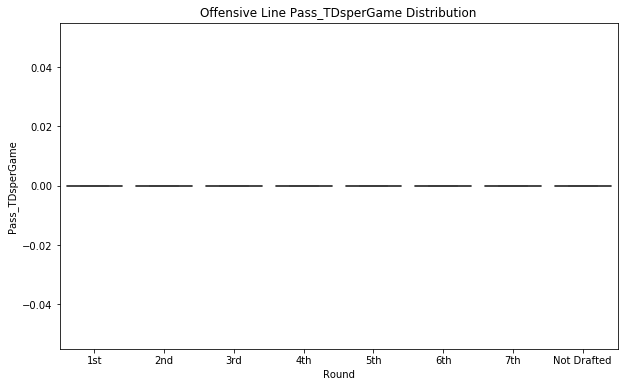

Offensive Line Pass_InterceptionsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pass_InterceptionsperGame, dtype: float64
----------------------------------------
Offensive Line Pass_InterceptionsperGame by Round
             Pass_InterceptionsperGame
Round                                 
1st                               0.00
2nd                               0.00
3rd                               0.00
4th                               0.00
5th                               0.00
6th                               0.00
7th                               0.00
Not Drafted                       0.00


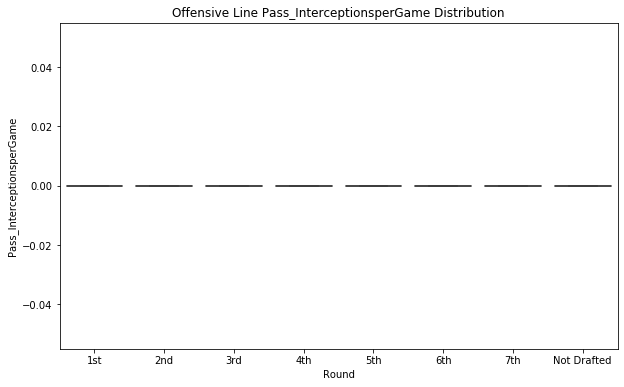

In [23]:
plot_stats('Offensive Line', df, passing_stats)

In [24]:
for i in passing_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Offensive Line', df, i)
    print('')
    print('*' * 40)

Passing_Games ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00    1.54     0.22 0.46    0.86
Residual 554.00  263.43     0.48  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1    group2   meandiff p-adj  lower  upper  reject
-------------------------------------------------------
   1st         2nd  -0.1179   0.9 -0.4595 0.2236  False
   1st         3rd  -0.1333   0.9 -0.4614 0.1947  False
   1st         4th  -0.1333   0.9 -0.4704 0.2038  False
   1st         5th  -0.1333   0.9 -0.4904 0.2238  False
   1st         6th  -0.1333   0.9 -0.5223 0.2556  False
   1st         7th  -0.1333   0.9 -0.5392 0.2726  False
   1st Not Drafted  -0.0467   0.9 -0.3358 0.2424  False
   2nd         3rd  -0.0154   0.9 -0.3709 0.3402  False
   2nd         4th  -0.0154   0.9 -0.3793 0.3486  False
   2nd         5th  -0.0154   0.9 -0.3979 0.3671  False
   2nd         6th  -0.0154   0.9 -0.4278  0.397  False
   2nd    


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
 


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.


NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.0 0.5566   0.0   0.0  False
   1st         6th      0.0 0.5566   0.0   0.0  False
   1st         7th      0.0 0.5566   0.0   0.0  False
   1st Not Drafted      0.0 0.5566   0.0   0.0  False
   2nd         3rd      0.0 0.5566   0.0   0.0  False
   2nd         4th      0.0 0.5566   0.0   0.0  False
   2nd         5th      0.0 0.5566   0.0   0.0  False
   2nd         6th      0.0 0.5566   0.0   0.0  False
   2nd         7th      0.0 0.5566   0.0   0.0  False
   2nd Not Drafted      0.0 0.5566   0.0   0.0  False
   3rd         4th      0.0 0.5566   0.0   0.0  False
   3rd 

### College Stats - Rushing & Receiving

In [25]:
rushing_stats = ['Rush_Rec_Games', 'Rush_Attempts', 'Rush_Yds', 'Rush_Yds_per_Attempt', 'Rush_TDs', 
                 'Receptions', 'Rec_Yds', 'Rec_Yds_per_Reception', 'Rec_TDs', 'Plays_from_Scrimmage', 'Scrimmage_Yds',
                 'Scrimmage_Yds_per_Attempt', 'Scrimmage_TDs', 'Rush_AttemptsperGame', 'Rush_YdsperGame', 
                 'Rush_TDsperGame', 'ReceptionsperGame', 'Rec_YdsperGame', 'Rec_TDsperGame', 
                 'Plays_from_ScrimmageperGame', 'Scrimmage_YdsperGame', 'Scrimmage_TDsperGame']

In [26]:
df[rushing_stats].describe()

,Rush_Rec_Games,Rush_Attempts,Rush_Yds,Rush_Yds_per_Attempt,Rush_TDs,Receptions,Rec_Yds,Rec_Yds_per_Reception,Rec_TDs,Plays_from_Scrimmage,Scrimmage_Yds,Scrimmage_Yds_per_Attempt,Scrimmage_TDs,Rush_AttemptsperGame,Rush_YdsperGame,Rush_TDsperGame,ReceptionsperGame,Rec_YdsperGame,Rec_TDsperGame,Plays_from_ScrimmageperGame,Scrimmage_YdsperGame,Scrimmage_TDsperGame
count,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00
mean,0.36,0.23,0.84,0.15,0.02,0.01,0.06,0.01,0.00,0.24,0.90,0.15,0.02,0.04,0.08,0.01,0.00,0.00,0.00,0.04,0.08,0.01
std,1.96,4.10,15.82,1.57,0.29,0.25,1.31,0.22,0.00,4.35,17.12,1.57,0.29,0.32,1.43,0.09,0.02,0.09,0.00,0.34,1.51,0.09
min,0.00,0.00,-9.00,-9.00,0.00,0.00,0.00,0.00,0.00,0.00,-9.00,-9.00,0.00,0.00,-9.00,0.00,0.00,0.00,0.00,0.00,-9.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,14.00,97.00,371.00,24.50,6.00,6.00,31.00,5.20,0.00,103.00,402.00,24.50,6.00,6.93,26.50,1.00,0.43,2.21,0.00,7.36,28.71,1.00


Offensive Line Rush_Rec_Games Summary:
count   562.00
mean      0.36
std       1.96
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      14.00
Name: Rush_Rec_Games, dtype: float64
----------------------------------------
Offensive Line Rush_Rec_Games by Round
             Rush_Rec_Games
Round                      
1st                    0.46
2nd                    0.29
3rd                    0.67
4th                    0.26
5th                    0.71
6th                    0.02
7th                    0.34
Not Drafted            0.14


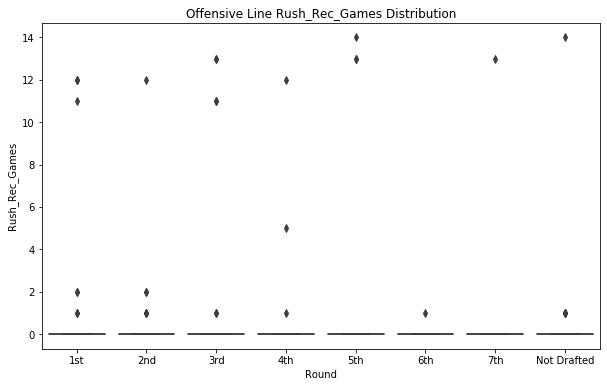

Offensive Line Rush_Attempts Summary:
count   562.00
mean      0.23
std       4.10
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      97.00
Name: Rush_Attempts, dtype: float64
----------------------------------------
Offensive Line Rush_Attempts by Round
             Rush_Attempts
Round                     
1st                   0.09
2nd                   0.08
3rd                   0.07
4th                   0.07
5th                   0.04
6th                   0.02
7th                   0.03
Not Drafted           0.80


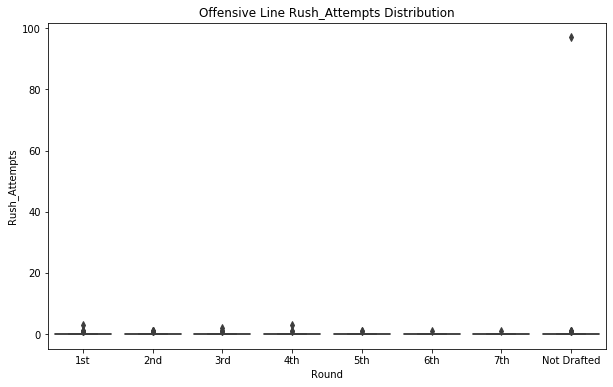

Offensive Line Rush_Yds Summary:
count   562.00
mean      0.84
std      15.82
min      -9.00
25%       0.00
50%       0.00
75%       0.00
max     371.00
Name: Rush_Yds, dtype: float64
----------------------------------------
Offensive Line Rush_Yds by Round
             Rush_Yds
Round                
1st              0.17
2nd              0.32
3rd              0.95
4th              0.01
5th              0.07
6th             -0.21
7th              0.08
Not Drafted      2.89


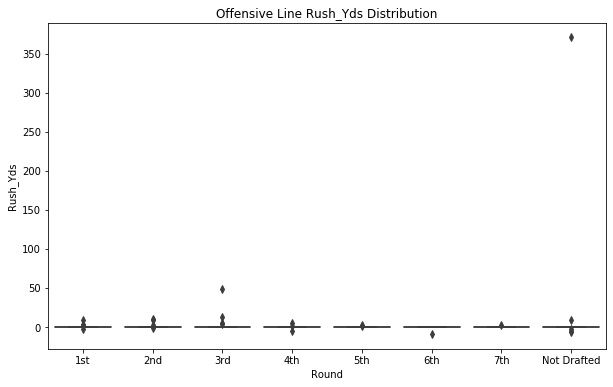

Offensive Line Rush_Yds_per_Attempt Summary:
count   562.00
mean      0.15
std       1.57
min      -9.00
25%       0.00
50%       0.00
75%       0.00
max      24.50
Name: Rush_Yds_per_Attempt, dtype: float64
----------------------------------------
Offensive Line Rush_Yds_per_Attempt by Round
             Rush_Yds_per_Attempt
Round                            
1st                          0.14
2nd                          0.32
3rd                          0.62
4th                          0.06
5th                          0.07
6th                         -0.21
7th                          0.08
Not Drafted                 -0.00


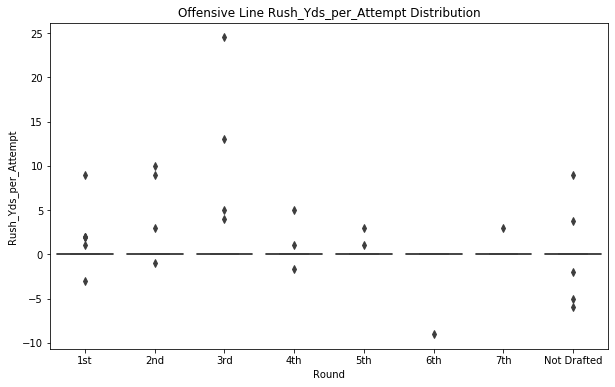

Offensive Line Rush_TDs Summary:
count   562.00
mean      0.02
std       0.29
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       6.00
Name: Rush_TDs, dtype: float64
----------------------------------------
Offensive Line Rush_TDs by Round
             Rush_TDs
Round                
1st              0.04
2nd              0.02
3rd              0.00
4th              0.03
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.06


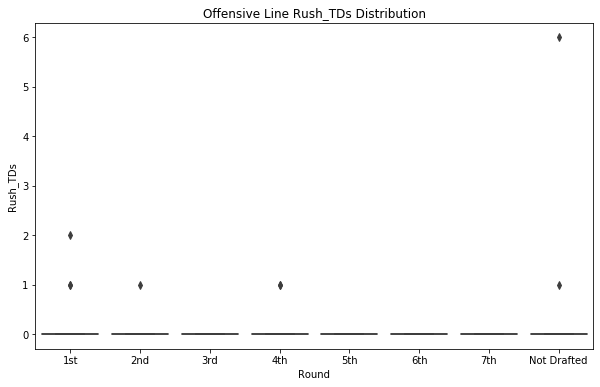

Offensive Line Receptions Summary:
count   562.00
mean      0.01
std       0.25
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       6.00
Name: Receptions, dtype: float64
----------------------------------------
Offensive Line Receptions by Round
             Receptions
Round                  
1st                0.00
2nd                0.00
3rd                0.00
4th                0.00
5th                0.00
6th                0.00
7th                0.00
Not Drafted        0.05


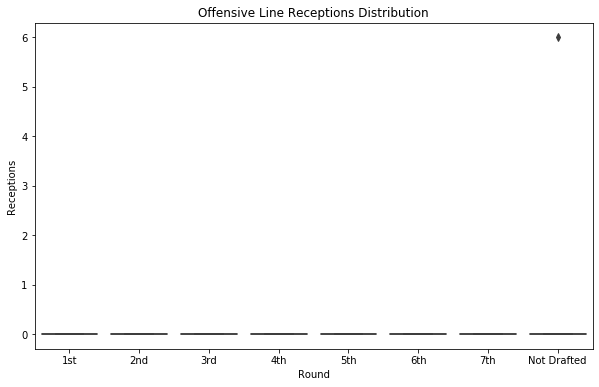

Offensive Line Rec_Yds Summary:
count   562.00
mean      0.06
std       1.31
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      31.00
Name: Rec_Yds, dtype: float64
----------------------------------------
Offensive Line Rec_Yds by Round
             Rec_Yds
Round               
1st             0.00
2nd             0.00
3rd             0.00
4th             0.00
5th             0.00
6th             0.00
7th             0.00
Not Drafted     0.24


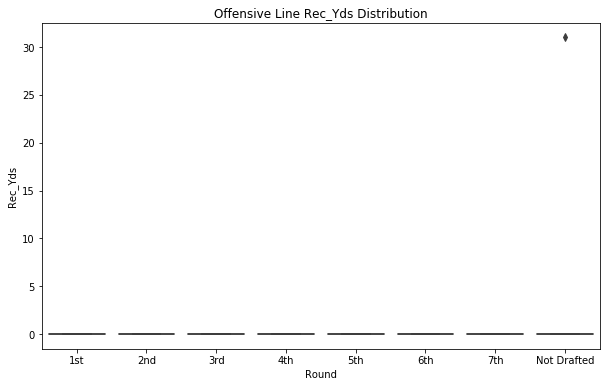

Offensive Line Rec_Yds_per_Reception Summary:
count   562.00
mean      0.01
std       0.22
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       5.20
Name: Rec_Yds_per_Reception, dtype: float64
----------------------------------------
Offensive Line Rec_Yds_per_Reception by Round
             Rec_Yds_per_Reception
Round                             
1st                           0.00
2nd                           0.00
3rd                           0.00
4th                           0.00
5th                           0.00
6th                           0.00
7th                           0.00
Not Drafted                   0.04


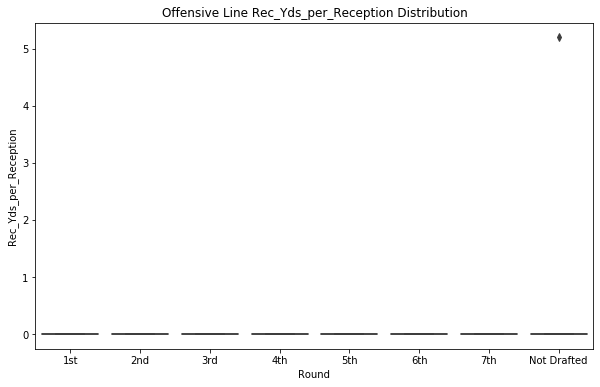

Offensive Line Rec_TDs Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Rec_TDs, dtype: float64
----------------------------------------
Offensive Line Rec_TDs by Round
             Rec_TDs
Round               
1st             0.00
2nd             0.00
3rd             0.00
4th             0.00
5th             0.00
6th             0.00
7th             0.00
Not Drafted     0.00


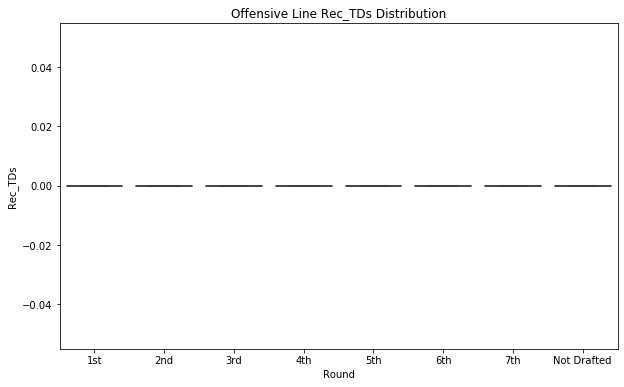

Offensive Line Plays_from_Scrimmage Summary:
count   562.00
mean      0.24
std       4.35
min       0.00
25%       0.00
50%       0.00
75%       0.00
max     103.00
Name: Plays_from_Scrimmage, dtype: float64
----------------------------------------
Offensive Line Plays_from_Scrimmage by Round
             Plays_from_Scrimmage
Round                            
1st                          0.09
2nd                          0.08
3rd                          0.07
4th                          0.07
5th                          0.04
6th                          0.02
7th                          0.03
Not Drafted                  0.84


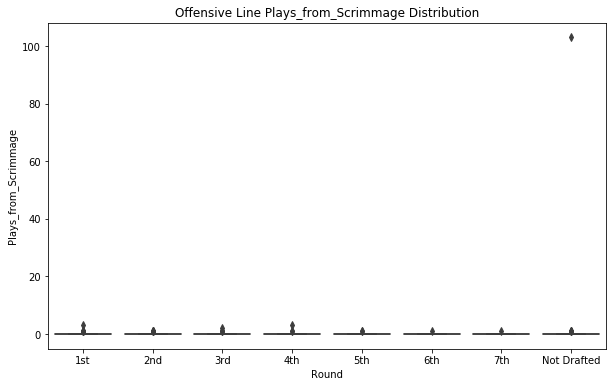

Offensive Line Scrimmage_Yds Summary:
count   562.00
mean      0.90
std      17.12
min      -9.00
25%       0.00
50%       0.00
75%       0.00
max     402.00
Name: Scrimmage_Yds, dtype: float64
----------------------------------------
Offensive Line Scrimmage_Yds by Round
             Scrimmage_Yds
Round                     
1st                   0.17
2nd                   0.32
3rd                   0.95
4th                   0.01
5th                   0.07
6th                  -0.21
7th                   0.08
Not Drafted           3.13


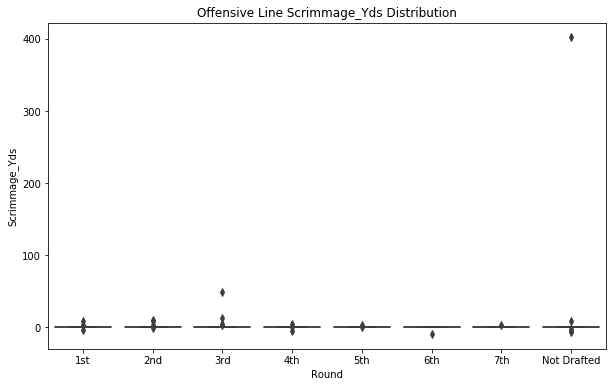

Offensive Line Scrimmage_Yds_per_Attempt Summary:
count   562.00
mean      0.15
std       1.57
min      -9.00
25%       0.00
50%       0.00
75%       0.00
max      24.50
Name: Scrimmage_Yds_per_Attempt, dtype: float64
----------------------------------------
Offensive Line Scrimmage_Yds_per_Attempt by Round
             Scrimmage_Yds_per_Attempt
Round                                 
1st                               0.14
2nd                               0.32
3rd                               0.62
4th                               0.06
5th                               0.07
6th                              -0.21
7th                               0.08
Not Drafted                      -0.00


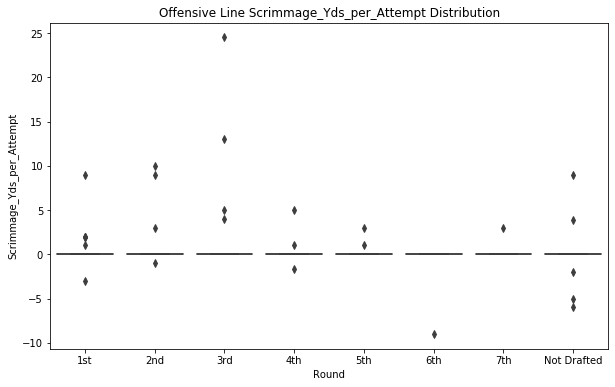

Offensive Line Scrimmage_TDs Summary:
count   562.00
mean      0.02
std       0.29
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       6.00
Name: Scrimmage_TDs, dtype: float64
----------------------------------------
Offensive Line Scrimmage_TDs by Round
             Scrimmage_TDs
Round                     
1st                   0.04
2nd                   0.02
3rd                   0.00
4th                   0.03
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.06


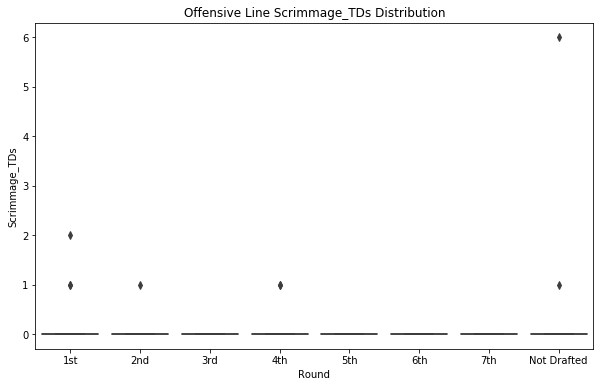

Offensive Line Rush_AttemptsperGame Summary:
count   562.00
mean      0.04
std       0.32
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       6.93
Name: Rush_AttemptsperGame, dtype: float64
----------------------------------------
Offensive Line Rush_AttemptsperGame by Round
             Rush_AttemptsperGame
Round                            
1st                          0.03
2nd                          0.06
3rd                          0.01
4th                          0.02
5th                          0.00
6th                          0.02
7th                          0.00
Not Drafted                  0.09


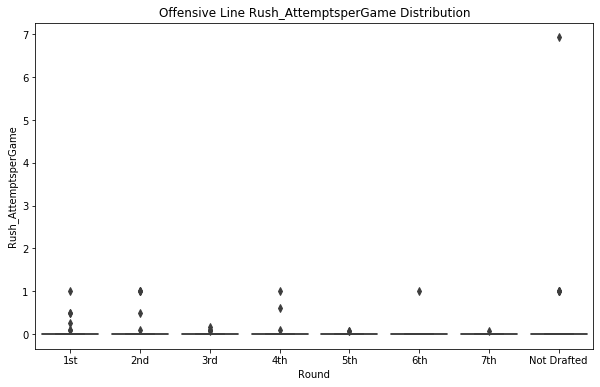

Offensive Line Rush_YdsperGame Summary:
count   562.00
mean      0.08
std       1.43
min      -9.00
25%       0.00
50%       0.00
75%       0.00
max      26.50
Name: Rush_YdsperGame, dtype: float64
----------------------------------------
Offensive Line Rush_YdsperGame by Round
             Rush_YdsperGame
Round                       
1st                     0.06
2nd                     0.30
3rd                     0.07
4th                     0.01
5th                     0.01
6th                    -0.21
7th                     0.01
Not Drafted             0.18


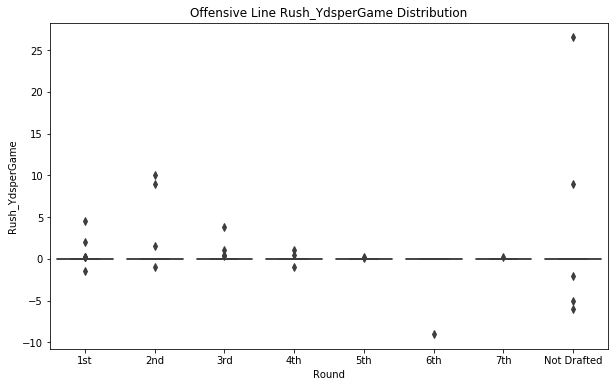

Offensive Line Rush_TDsperGame Summary:
count   562.00
mean      0.01
std       0.09
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Rush_TDsperGame, dtype: float64
----------------------------------------
Offensive Line Rush_TDsperGame by Round
             Rush_TDsperGame
Round                       
1st                     0.02
2nd                     0.02
3rd                     0.00
4th                     0.02
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.01


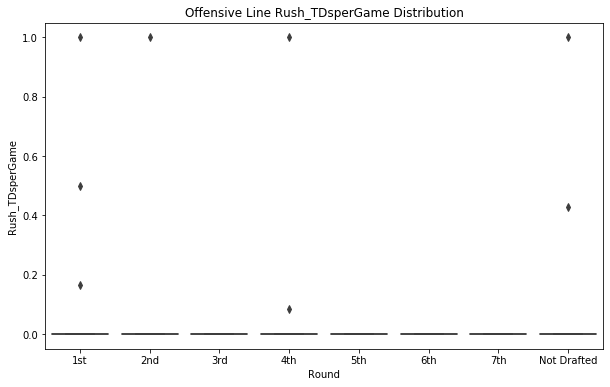

Offensive Line ReceptionsperGame Summary:
count   562.00
mean      0.00
std       0.02
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.43
Name: ReceptionsperGame, dtype: float64
----------------------------------------
Offensive Line ReceptionsperGame by Round
             ReceptionsperGame
Round                         
1st                       0.00
2nd                       0.00
3rd                       0.00
4th                       0.00
5th                       0.00
6th                       0.00
7th                       0.00
Not Drafted               0.00


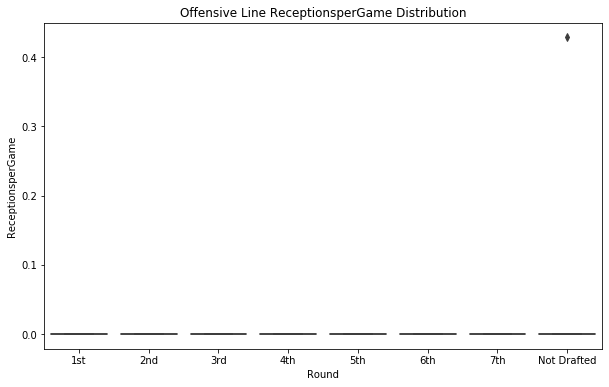

Offensive Line Rec_YdsperGame Summary:
count   562.00
mean      0.00
std       0.09
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       2.21
Name: Rec_YdsperGame, dtype: float64
----------------------------------------
Offensive Line Rec_YdsperGame by Round
             Rec_YdsperGame
Round                      
1st                    0.00
2nd                    0.00
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.00
7th                    0.00
Not Drafted            0.02


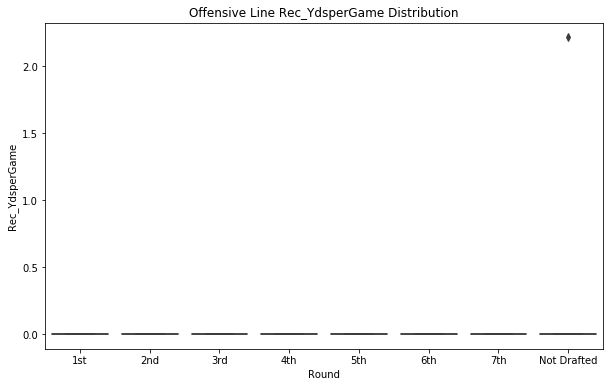

Offensive Line Rec_TDsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Rec_TDsperGame, dtype: float64
----------------------------------------
Offensive Line Rec_TDsperGame by Round
             Rec_TDsperGame
Round                      
1st                    0.00
2nd                    0.00
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.00
7th                    0.00
Not Drafted            0.00


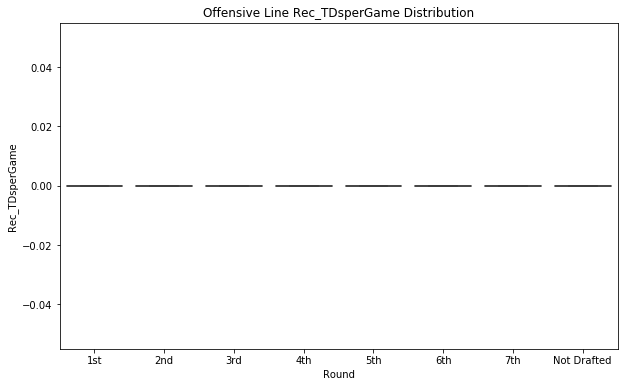

Offensive Line Plays_from_ScrimmageperGame Summary:
count   562.00
mean      0.04
std       0.34
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       7.36
Name: Plays_from_ScrimmageperGame, dtype: float64
----------------------------------------
Offensive Line Plays_from_ScrimmageperGame by Round
             Plays_from_ScrimmageperGame
Round                                   
1st                                 0.03
2nd                                 0.06
3rd                                 0.01
4th                                 0.02
5th                                 0.00
6th                                 0.02
7th                                 0.00
Not Drafted                         0.09


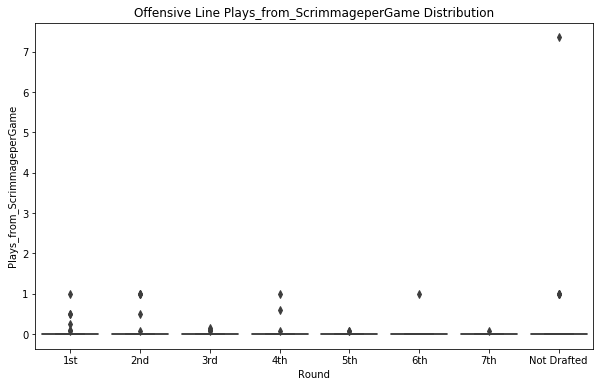

Offensive Line Scrimmage_YdsperGame Summary:
count   562.00
mean      0.08
std       1.51
min      -9.00
25%       0.00
50%       0.00
75%       0.00
max      28.71
Name: Scrimmage_YdsperGame, dtype: float64
----------------------------------------
Offensive Line Scrimmage_YdsperGame by Round
             Scrimmage_YdsperGame
Round                            
1st                          0.06
2nd                          0.30
3rd                          0.07
4th                          0.01
5th                          0.01
6th                         -0.21
7th                          0.01
Not Drafted                  0.19


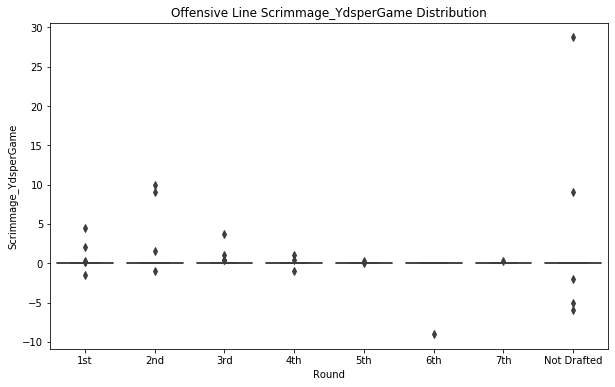

Offensive Line Scrimmage_TDsperGame Summary:
count   562.00
mean      0.01
std       0.09
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Scrimmage_TDsperGame, dtype: float64
----------------------------------------
Offensive Line Scrimmage_TDsperGame by Round
             Scrimmage_TDsperGame
Round                            
1st                          0.02
2nd                          0.02
3rd                          0.00
4th                          0.02
5th                          0.00
6th                          0.00
7th                          0.00
Not Drafted                  0.01


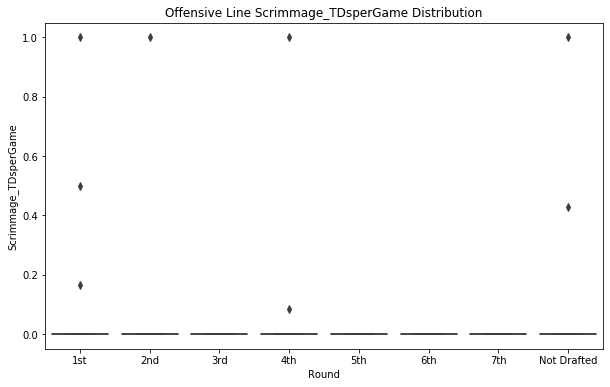

In [27]:
plot_stats('Offensive Line', df, rushing_stats)

In [28]:
for i in rushing_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Offensive Line', df, i)
    print('')
    print('*' * 40)

Rush_Rec_Games ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   26.75     3.82 0.99    0.44
Residual 554.00 2132.08     3.85  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.1632    0.9 -1.1348 0.8083  False
   1st         3rd   0.2111    0.9 -0.7221 1.1443  False
   1st         4th  -0.1908    0.9 -1.1499 0.7682  False
   1st         5th   0.2587    0.9 -0.7571 1.2746  False
   1st         6th  -0.4323    0.9 -1.5388 0.6742  False
   1st         7th  -0.1135    0.9 -1.2682 1.0413  False
   1st Not Drafted  -0.3138    0.9 -1.1362 0.5086  False
   2nd         3rd   0.3744    0.9 -0.6371 1.3858  False
   2nd         4th  -0.0276    0.9  -1.063 1.0078  False
   2nd         5th    0.422    0.9 -0.6663 1.5102  False
   2nd         6th  -0.2691    0.9 -1.4423 0.9042  F

             df  sum_sq  mean_sq   F  PR(>F)
Round      7.00    0.00     0.00 nan     nan
Residual 554.00    0.00     0.00 nan     nan


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-------------------------------

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0291    0.9 -0.1708 0.1127  False
   1st         3rd  -0.0444    0.9 -0.1806 0.0917  False
   1st         4th   -0.015    0.9 -0.1549 0.1249  False
   1st         5th  -0.0444    0.9 -0.1926 0.1037  False
   1st         6th  -0.0444    0.9 -0.2058  0.117  False
   1st         7th  -0.0444    0.9 -0.2129  0.124  False
   1st Not Drafted   0.0107    0.9 -0.1093 0.1306  False
   2nd         3rd  -0.0154    0.9 -0.1629 0.1322  False
   2nd         4th    0.014    0.9  -0.137  0.165  False
   2nd         5th  -0.0154    0.9 -0.1741 0.1433  False
   2nd         6th  -0.0154    0.9 -0.1865 0.1558  False
   2nd         7th  -0.0154    0.9 -0.1932 0.1624  False
   2nd Not Drafted   0.0397    0.9  -0.093 0.1725  False
   3rd         4th   0.0294    0.9 -0.1164 0.1752  False
   3rd         5th      0.0    


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1s

### College Stats - Defense

In [29]:
defense_stats = ['Defense_Games', 'Solo_Tackles', 'Assisted_Tackles', 'Ttl_Tackles', 'Loss', 'Sacks', 
                 'Defensive_Interceptions', 'Def_Int_Yds', 'Yds_per_Int', 'Pick_6', 'Defended_Passes', 
                 'Recovered_Fumbles', 'Rec_Fumbles_Yds', 'Fumbles_Returned_TD', 'Forced_Fumbles', 
                 'Solo_TacklesperGame', 'Assisted_TacklesperGame', 'Ttl_TacklesperGame', 'LossperGame', 
                 'SacksperGame', 'Defensive_InterceptionsperGame', 'Def_Int_YdsperGame', 'Pick_6perGame', 
                 'Defended_PassesperGame', 'Recovered_FumblesperGame', 'Rec_Fumbles_YdsperGame', 
                 'Fumbles_Returned_TDperGame', 'Forced_FumblesperGame']

In [30]:
df[defense_stats].describe()

,Defense_Games,Solo_Tackles,Assisted_Tackles,Ttl_Tackles,Loss,Sacks,Defensive_Interceptions,Def_Int_Yds,Yds_per_Int,Pick_6,Defended_Passes,Recovered_Fumbles,Rec_Fumbles_Yds,Fumbles_Returned_TD,Forced_Fumbles,Solo_TacklesperGame,Assisted_TacklesperGame,Ttl_TacklesperGame,LossperGame,SacksperGame,Defensive_InterceptionsperGame,Def_Int_YdsperGame,Pick_6perGame,Defended_PassesperGame,Recovered_FumblesperGame,Rec_Fumbles_YdsperGame,Fumbles_Returned_TDperGame,Forced_FumblesperGame
count,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00
mean,3.67,0.63,0.19,0.82,0.03,0.01,0.00,0.02,0.02,0.00,0.01,0.00,0.00,0.01,0.01,inf,inf,inf,inf,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,5.37,1.23,1.04,2.09,0.43,0.17,0.06,0.38,0.38,0.00,0.10,0.06,0.00,0.07,0.10,nan,nan,nan,nan,0.01,0.01,0.03,0.00,0.01,0.04,0.00,0.04,0.04
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,11.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17,0.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,14.00,19.00,18.00,37.00,9.00,4.00,1.00,9.00,9.00,0.00,2.00,1.00,0.00,1.00,2.00,inf,inf,inf,inf,0.33,0.20,0.69,0.00,0.20,1.00,0.00,1.00,1.00


Offensive Line Defense_Games Summary:
count   562.00
mean      3.67
std       5.37
min       0.00
25%       0.00
50%       1.00
75%      11.00
max      14.00
Name: Defense_Games, dtype: float64
----------------------------------------
Offensive Line Defense_Games by Round
             Defense_Games
Round                     
1st                   3.72
2nd                   3.54
3rd                   3.41
4th                   4.04
5th                   3.20
6th                   3.98
7th                   4.00
Not Drafted           3.65


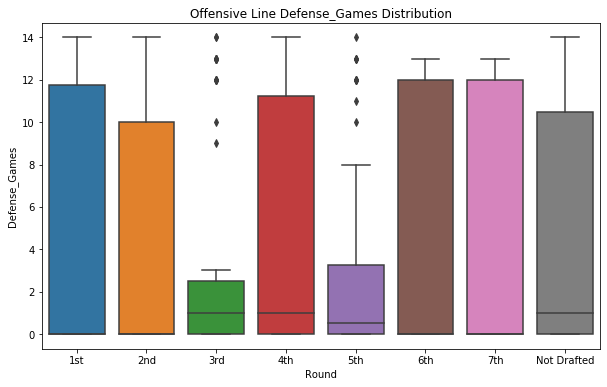

Offensive Line Solo_Tackles Summary:
count   562.00
mean      0.63
std       1.23
min       0.00
25%       0.00
50%       0.00
75%       1.00
max      19.00
Name: Solo_Tackles, dtype: float64
----------------------------------------
Offensive Line Solo_Tackles by Round
             Solo_Tackles
Round                    
1st                  0.54
2nd                  0.58
3rd                  0.65
4th                  0.84
5th                  0.59
6th                  0.49
7th                  0.50
Not Drafted          0.69


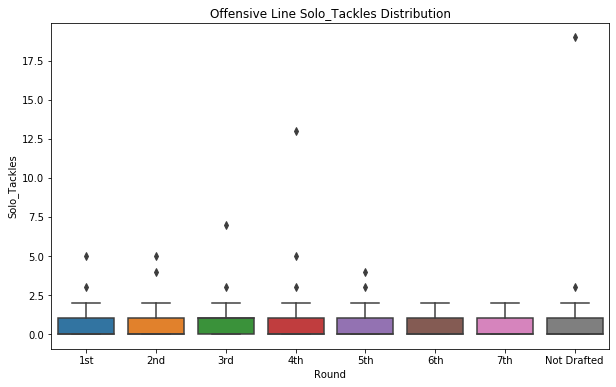

Offensive Line Assisted_Tackles Summary:
count   562.00
mean      0.19
std       1.04
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      18.00
Name: Assisted_Tackles, dtype: float64
----------------------------------------
Offensive Line Assisted_Tackles by Round
             Assisted_Tackles
Round                        
1st                      0.12
2nd                      0.37
3rd                      0.24
4th                      0.19
5th                      0.09
6th                      0.09
7th                      0.08
Not Drafted              0.23


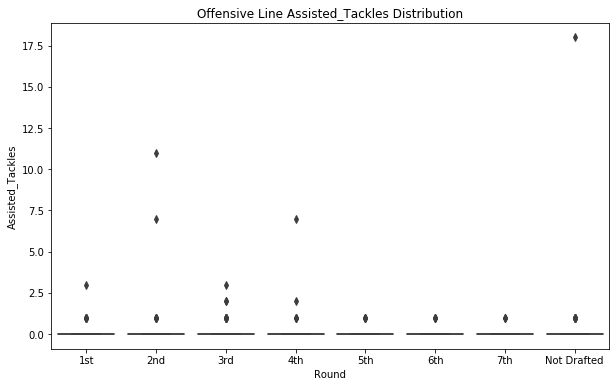

Offensive Line Ttl_Tackles Summary:
count   562.00
mean      0.82
std       2.09
min       0.00
25%       0.00
50%       1.00
75%       1.00
max      37.00
Name: Ttl_Tackles, dtype: float64
----------------------------------------
Offensive Line Ttl_Tackles by Round
             Ttl_Tackles
Round                   
1st                 0.67
2nd                 0.95
3rd                 0.89
4th                 1.03
5th                 0.68
6th                 0.58
7th                 0.58
Not Drafted         0.92


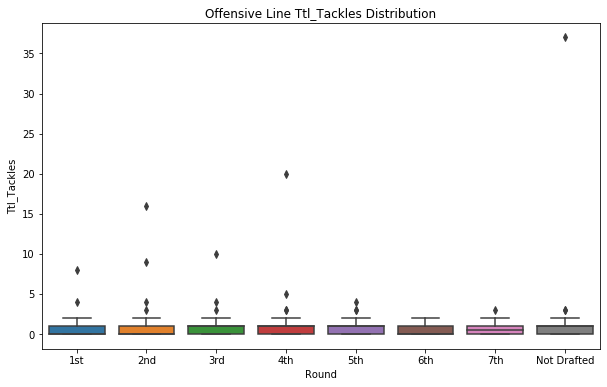

Offensive Line Loss Summary:
count   562.00
mean      0.03
std       0.43
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       9.00
Name: Loss, dtype: float64
----------------------------------------
Offensive Line Loss by Round
             Loss
Round            
1st          0.01
2nd          0.02
3rd          0.07
4th          0.01
5th          0.00
6th          0.00
7th          0.00
Not Drafted  0.07


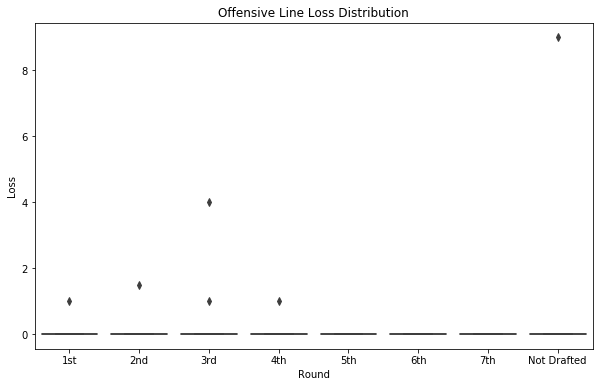

Offensive Line Sacks Summary:
count   562.00
mean      0.01
std       0.17
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       4.00
Name: Sacks, dtype: float64
----------------------------------------
Offensive Line Sacks by Round
             Sacks
Round             
1st           0.00
2nd           0.00
3rd           0.00
4th           0.00
5th           0.00
6th           0.00
7th           0.00
Not Drafted   0.03


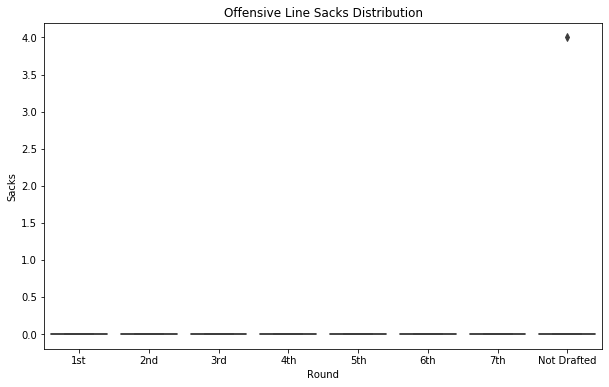

Offensive Line Defensive_Interceptions Summary:
count   562.00
mean      0.00
std       0.06
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Defensive_Interceptions, dtype: float64
----------------------------------------
Offensive Line Defensive_Interceptions by Round
             Defensive_Interceptions
Round                               
1st                             0.01
2nd                             0.00
3rd                             0.00
4th                             0.01
5th                             0.00
6th                             0.00
7th                             0.00
Not Drafted                     0.00


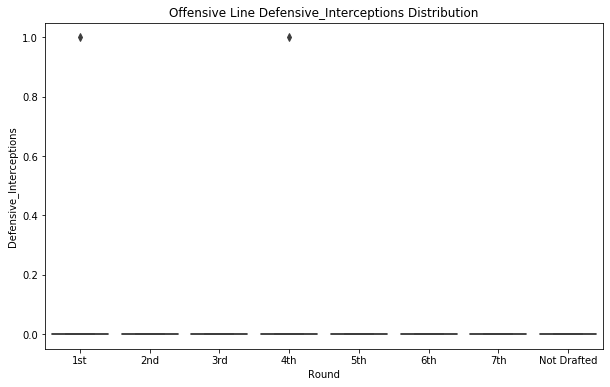

Offensive Line Def_Int_Yds Summary:
count   562.00
mean      0.02
std       0.38
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       9.00
Name: Def_Int_Yds, dtype: float64
----------------------------------------
Offensive Line Def_Int_Yds by Round
             Def_Int_Yds
Round                   
1st                 0.10
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.00


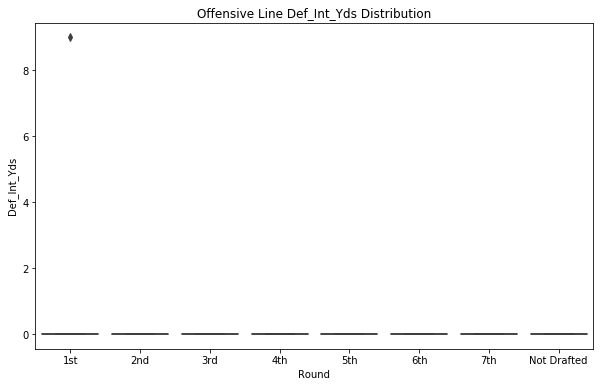

Offensive Line Yds_per_Int Summary:
count   562.00
mean      0.02
std       0.38
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       9.00
Name: Yds_per_Int, dtype: float64
----------------------------------------
Offensive Line Yds_per_Int by Round
             Yds_per_Int
Round                   
1st                 0.10
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.00


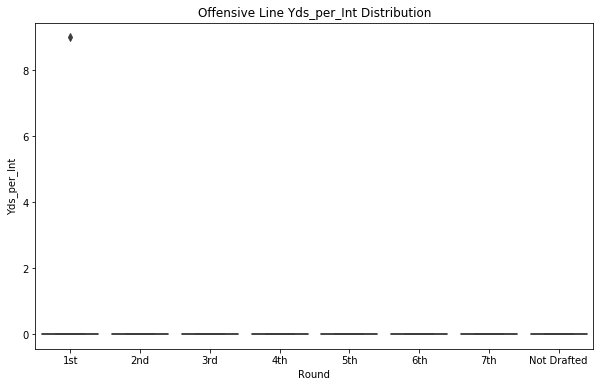

Offensive Line Pick_6 Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pick_6, dtype: float64
----------------------------------------
Offensive Line Pick_6 by Round
             Pick_6
Round              
1st            0.00
2nd            0.00
3rd            0.00
4th            0.00
5th            0.00
6th            0.00
7th            0.00
Not Drafted    0.00


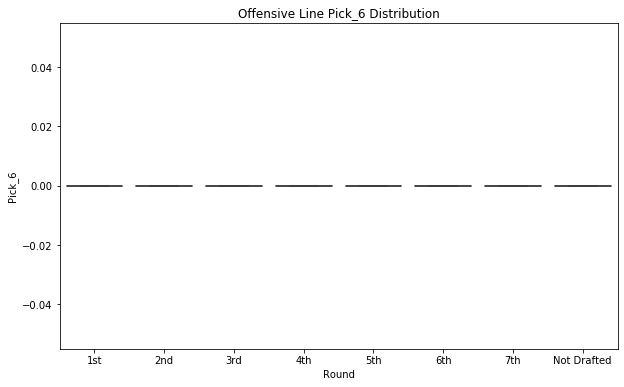

Offensive Line Defended_Passes Summary:
count   562.00
mean      0.01
std       0.10
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       2.00
Name: Defended_Passes, dtype: float64
----------------------------------------
Offensive Line Defended_Passes by Round
             Defended_Passes
Round                       
1st                     0.00
2nd                     0.02
3rd                     0.00
4th                     0.01
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.02


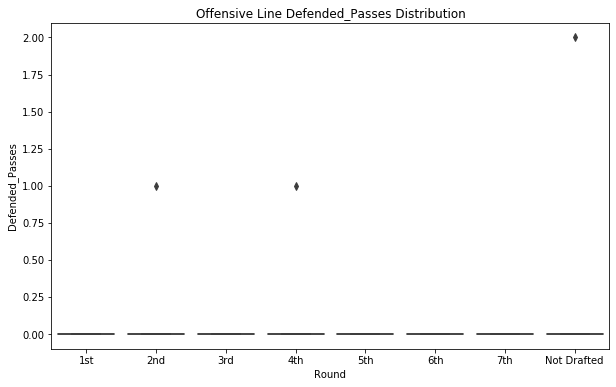

Offensive Line Recovered_Fumbles Summary:
count   562.00
mean      0.00
std       0.06
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Recovered_Fumbles, dtype: float64
----------------------------------------
Offensive Line Recovered_Fumbles by Round
             Recovered_Fumbles
Round                         
1st                       0.01
2nd                       0.00
3rd                       0.00
4th                       0.00
5th                       0.00
6th                       0.00
7th                       0.00
Not Drafted               0.01


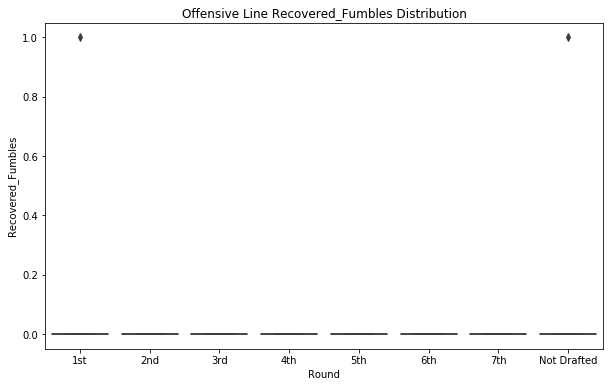

Offensive Line Rec_Fumbles_Yds Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Rec_Fumbles_Yds, dtype: float64
----------------------------------------
Offensive Line Rec_Fumbles_Yds by Round
             Rec_Fumbles_Yds
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


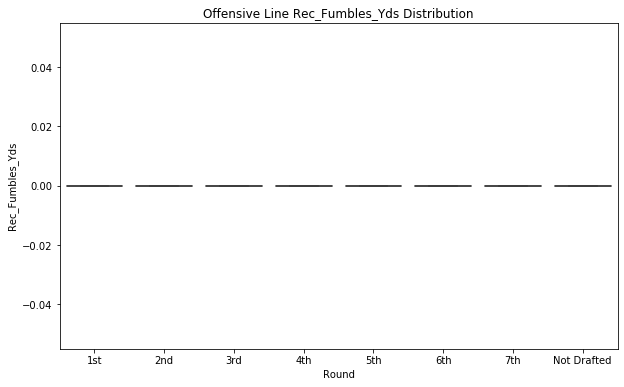

Offensive Line Fumbles_Returned_TD Summary:
count   562.00
mean      0.01
std       0.07
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Fumbles_Returned_TD, dtype: float64
----------------------------------------
Offensive Line Fumbles_Returned_TD by Round
             Fumbles_Returned_TD
Round                           
1st                         0.00
2nd                         0.00
3rd                         0.01
4th                         0.00
5th                         0.02
6th                         0.00
7th                         0.00
Not Drafted                 0.01


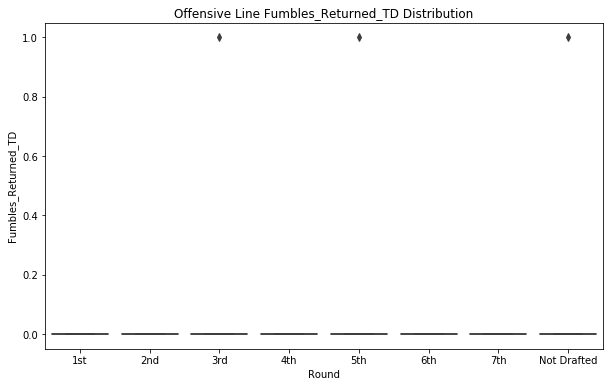

Offensive Line Forced_Fumbles Summary:
count   562.00
mean      0.01
std       0.10
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       2.00
Name: Forced_Fumbles, dtype: float64
----------------------------------------
Offensive Line Forced_Fumbles by Round
             Forced_Fumbles
Round                      
1st                    0.00
2nd                    0.00
3rd                    0.00
4th                    0.01
5th                    0.00
6th                    0.00
7th                    0.00
Not Drafted            0.02


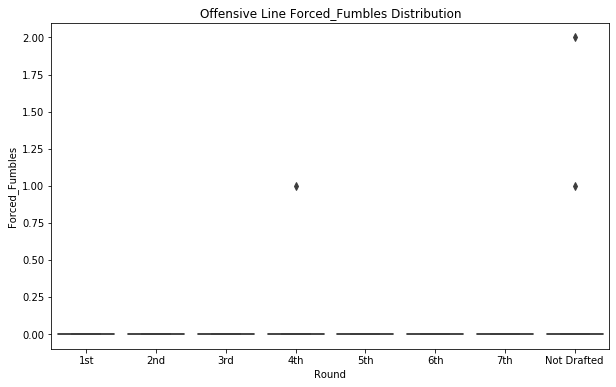

Offensive Line Solo_TacklesperGame Summary:
count   562.00
mean       inf
std        nan
min       0.00
25%       0.00
50%       0.00
75%       0.17
max        inf
Name: Solo_TacklesperGame, dtype: float64
----------------------------------------
Offensive Line Solo_TacklesperGame by Round
             Solo_TacklesperGame
Round                           
1st                          inf
2nd                          inf
3rd                          inf
4th                          inf
5th                          inf
6th                          inf
7th                          inf
Not Drafted                  inf


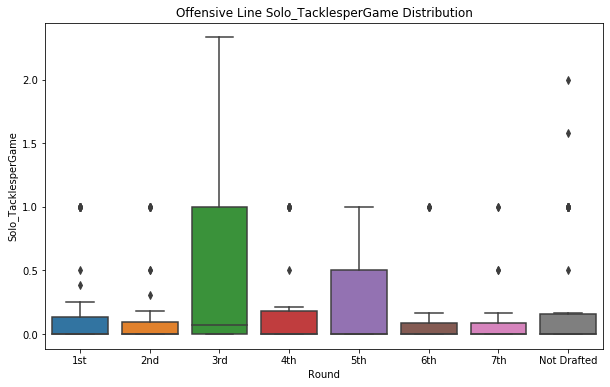

Offensive Line Assisted_TacklesperGame Summary:
count   562.00
mean       inf
std        nan
min       0.00
25%       0.00
50%       0.00
75%       0.00
max        inf
Name: Assisted_TacklesperGame, dtype: float64
----------------------------------------
Offensive Line Assisted_TacklesperGame by Round
             Assisted_TacklesperGame
Round                               
1st                             0.04
2nd                              inf
3rd                              inf
4th                              inf
5th                             0.03
6th                             0.03
7th                             0.01
Not Drafted                     0.06


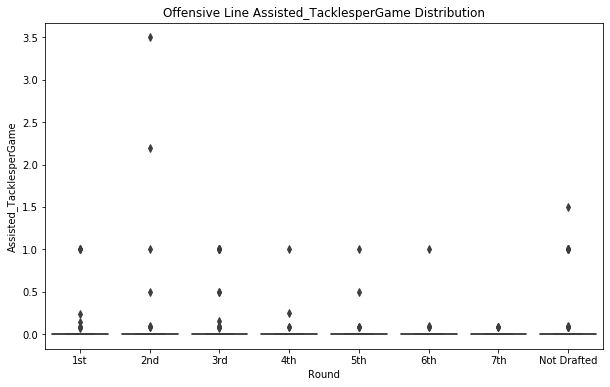

Offensive Line Ttl_TacklesperGame Summary:
count   562.00
mean       inf
std        nan
min       0.00
25%       0.00
50%       0.08
75%       0.50
max        inf
Name: Ttl_TacklesperGame, dtype: float64
----------------------------------------
Offensive Line Ttl_TacklesperGame by Round
             Ttl_TacklesperGame
Round                          
1st                         inf
2nd                         inf
3rd                         inf
4th                         inf
5th                         inf
6th                         inf
7th                         inf
Not Drafted                 inf


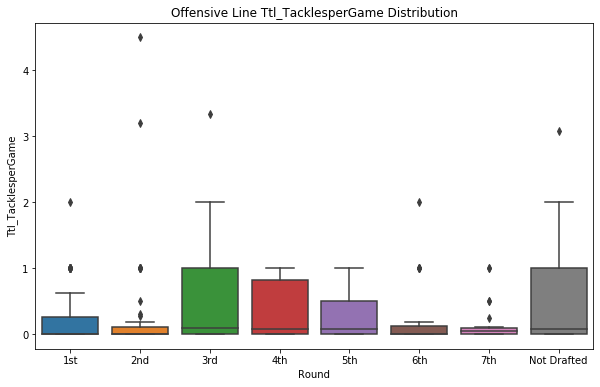

Offensive Line LossperGame Summary:
count   562.00
mean       inf
std        nan
min       0.00
25%       0.00
50%       0.00
75%       0.00
max        inf
Name: LossperGame, dtype: float64
----------------------------------------
Offensive Line LossperGame by Round
             LossperGame
Round                   
1st                 0.00
2nd                 0.01
3rd                 0.02
4th                  inf
5th                 0.00
6th                 0.00
7th                 0.00
Not Drafted         0.01


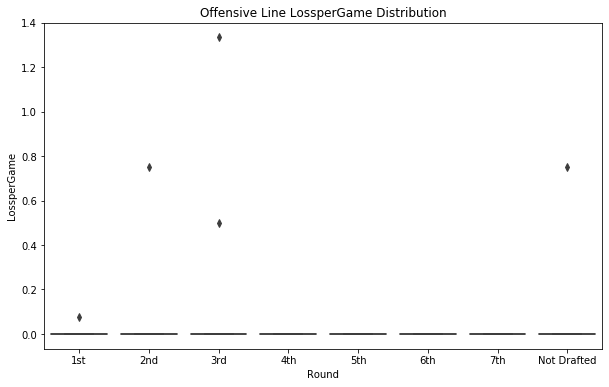

Offensive Line SacksperGame Summary:
count   562.00
mean      0.00
std       0.01
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.33
Name: SacksperGame, dtype: float64
----------------------------------------
Offensive Line SacksperGame by Round
             SacksperGame
Round                    
1st                  0.00
2nd                  0.00
3rd                  0.00
4th                  0.00
5th                  0.00
6th                  0.00
7th                  0.00
Not Drafted          0.00


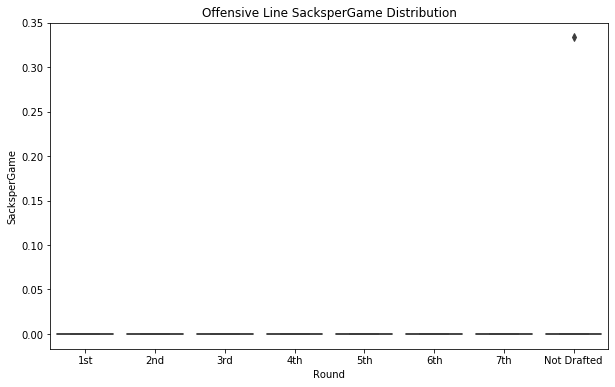

Offensive Line Defensive_InterceptionsperGame Summary:
count   562.00
mean      0.00
std       0.01
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.20
Name: Defensive_InterceptionsperGame, dtype: float64
----------------------------------------
Offensive Line Defensive_InterceptionsperGame by Round
             Defensive_InterceptionsperGame
Round                                      
1st                                    0.00
2nd                                    0.00
3rd                                    0.00
4th                                    0.00
5th                                    0.00
6th                                    0.00
7th                                    0.00
Not Drafted                            0.00


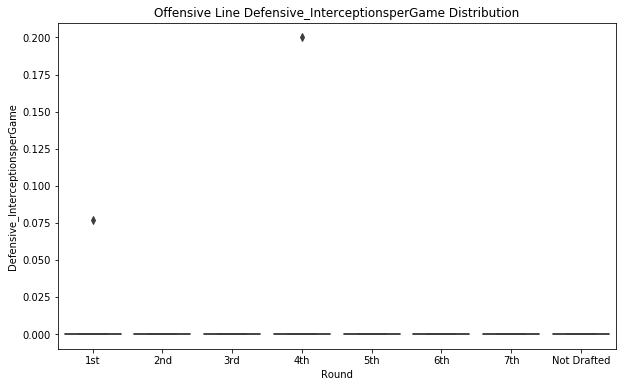

Offensive Line Def_Int_YdsperGame Summary:
count   562.00
mean      0.00
std       0.03
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.69
Name: Def_Int_YdsperGame, dtype: float64
----------------------------------------
Offensive Line Def_Int_YdsperGame by Round
             Def_Int_YdsperGame
Round                          
1st                        0.01
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


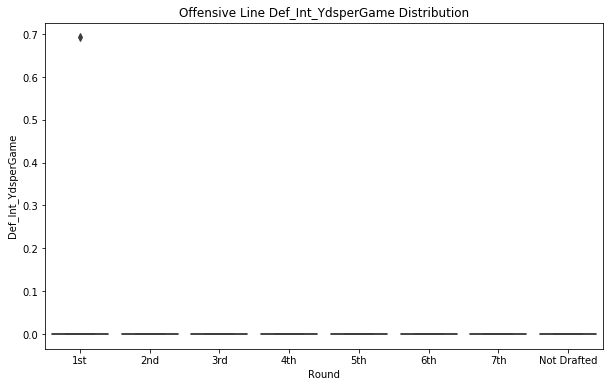

Offensive Line Pick_6perGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Pick_6perGame, dtype: float64
----------------------------------------
Offensive Line Pick_6perGame by Round
             Pick_6perGame
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


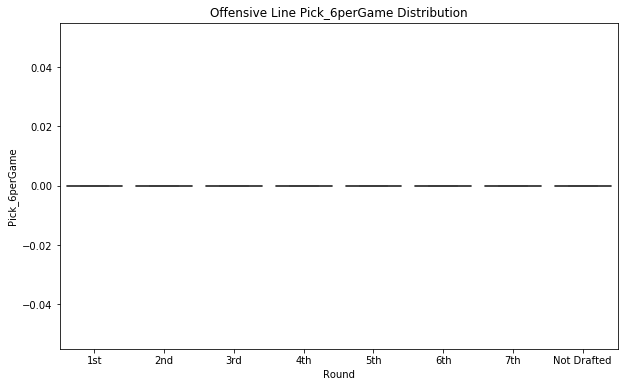

Offensive Line Defended_PassesperGame Summary:
count   562.00
mean      0.00
std       0.01
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.20
Name: Defended_PassesperGame, dtype: float64
----------------------------------------
Offensive Line Defended_PassesperGame by Round
             Defended_PassesperGame
Round                              
1st                            0.00
2nd                            0.00
3rd                            0.00
4th                            0.00
5th                            0.00
6th                            0.00
7th                            0.00
Not Drafted                    0.00


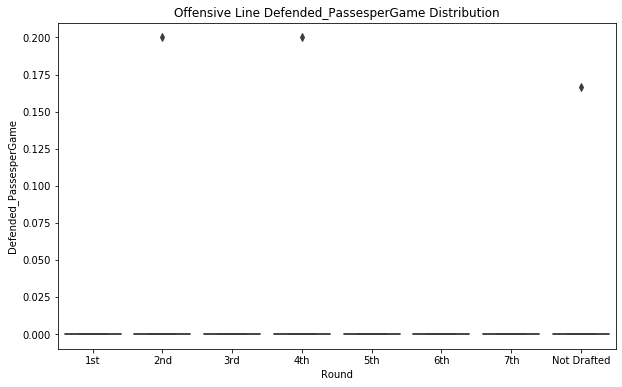

Offensive Line Recovered_FumblesperGame Summary:
count   562.00
mean      0.00
std       0.04
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Recovered_FumblesperGame, dtype: float64
----------------------------------------
Offensive Line Recovered_FumblesperGame by Round
             Recovered_FumblesperGame
Round                                
1st                              0.00
2nd                              0.00
3rd                              0.00
4th                              0.00
5th                              0.00
6th                              0.00
7th                              0.00
Not Drafted                      0.01


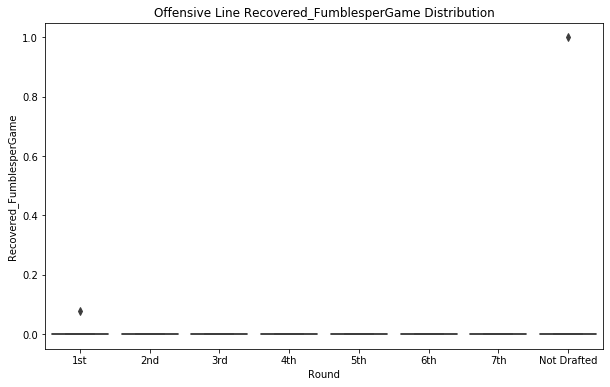

Offensive Line Rec_Fumbles_YdsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Rec_Fumbles_YdsperGame, dtype: float64
----------------------------------------
Offensive Line Rec_Fumbles_YdsperGame by Round
             Rec_Fumbles_YdsperGame
Round                              
1st                            0.00
2nd                            0.00
3rd                            0.00
4th                            0.00
5th                            0.00
6th                            0.00
7th                            0.00
Not Drafted                    0.00


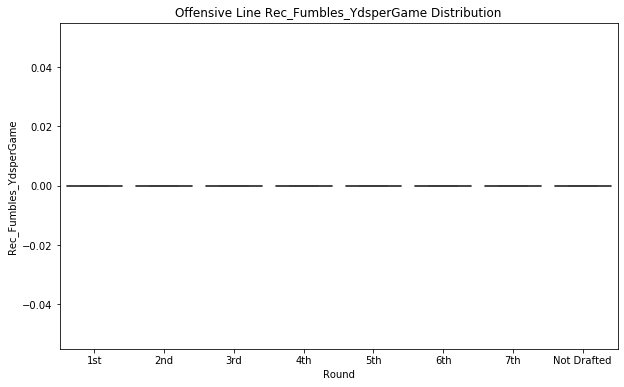

Offensive Line Fumbles_Returned_TDperGame Summary:
count   562.00
mean      0.00
std       0.04
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Fumbles_Returned_TDperGame, dtype: float64
----------------------------------------
Offensive Line Fumbles_Returned_TDperGame by Round
             Fumbles_Returned_TDperGame
Round                                  
1st                                0.00
2nd                                0.00
3rd                                0.00
4th                                0.00
5th                                0.02
6th                                0.00
7th                                0.00
Not Drafted                        0.00


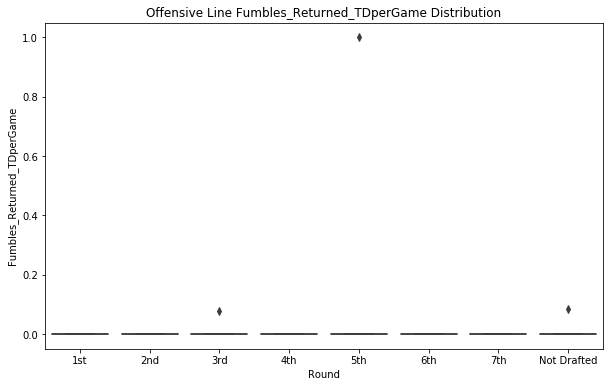

Offensive Line Forced_FumblesperGame Summary:
count   562.00
mean      0.00
std       0.04
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Forced_FumblesperGame, dtype: float64
----------------------------------------
Offensive Line Forced_FumblesperGame by Round
             Forced_FumblesperGame
Round                             
1st                           0.00
2nd                           0.00
3rd                           0.00
4th                           0.00
5th                           0.00
6th                           0.00
7th                           0.00
Not Drafted                   0.01


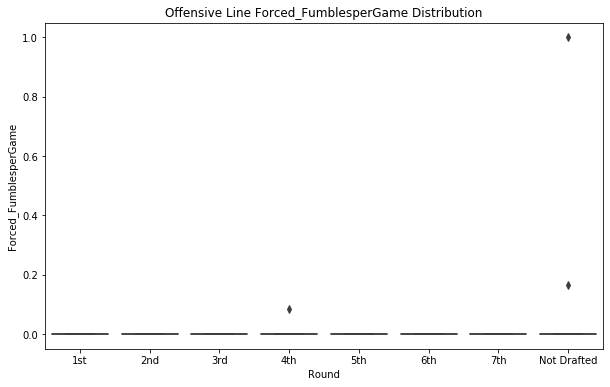

In [31]:
plot_stats('Offensive Line', df, defense_stats)

In [32]:
for i in defense_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Offensive Line', df, i)
    print('')
    print('*' * 40)

Defense_Games ANOVA Test:
----------------------------------------
             df   sum_sq  mean_sq    F  PR(>F)
Round      7.00    36.64     5.23 0.18    0.99
Residual 554.00 16166.13    29.18  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1    group2   meandiff p-adj  lower  upper  reject
-------------------------------------------------------
   1st         2nd  -0.1838   0.9  -2.859 2.4915  False
   1st         3rd  -0.3089   0.9 -2.8785 2.2607  False
   1st         4th   0.3219   0.9 -2.3189 2.9627  False
   1st         5th  -0.5258   0.9 -3.3231 2.2715  False
   1st         6th   0.2545   0.9 -2.7923 3.3014  False
   1st         7th   0.2778   0.9 -2.9018 3.4574  False
   1st Not Drafted  -0.0766   0.9 -2.3411  2.188  False
   2nd         3rd  -0.1251   0.9 -2.9103 2.6601  False
   2nd         4th   0.5057   0.9 -2.3453 3.3566  False
   2nd         5th   -0.342   0.9 -3.3386 2.6545  False
   2nd         6th   0.4383   0.9 -2.7925  3.669  False
   2nd 

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0111    0.9 -0.0407 0.0185  False
   1st         3rd  -0.0111    0.9 -0.0395 0.0173  False
   1st         4th   0.0036    0.9 -0.0256 0.0328  False
   1st         5th  -0.0111    0.9  -0.042 0.0198  False
   1st         6th  -0.0111    0.9 -0.0448 0.0226  False
   1st         7th  -0.0111    0.9 -0.0462  0.024  False
   1st Not Drafted  -0.0111  0.871 -0.0361 0.0139  False
   2nd         3rd      0.0    0.9 -0.0308 0.0308  False
   2nd         4th   0.0147 0.8297 -0.0168 0.0462  False
   2nd         5th      0.0    0.9 -0.0331 0.0331  False
   2nd         6th      0.0    0.9 -0.0357 0.0357  False
   2nd         7th      0.0    0.9 -0.0371 0.0371  False
   2nd Not Drafted      0.0    0.9 -0.0277 0.0277  False
   3rd         4th   0.0147 0.7994 -0.0157 0.0451  False
   3rd         5th      0.0    

             df  sum_sq  mean_sq   F  PR(>F)
Round      7.00    0.00     0.00 nan     nan
Residual 554.00    0.00     0.00 nan     nan


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-------------------------------

             df  sum_sq  mean_sq   F  PR(>F)
Round      7.00     nan      nan nan     nan
Residual 554.00     nan      nan nan     nan


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-------------------------------

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd      0.0    0.9  -0.007  0.007  False
   1st         3rd      0.0    0.9 -0.0067 0.0067  False
   1st         4th      0.0    0.9 -0.0069 0.0069  False
   1st         5th      0.0    0.9 -0.0073 0.0073  False
   1st         6th      0.0    0.9  -0.008  0.008  False
   1st         7th      0.0    0.9 -0.0083 0.0083  False
   1st Not Drafted   0.0026 0.8713 -0.0033 0.0085  False
   2nd         3rd      0.0    0.9 -0.0073 0.0073  False
   2nd         4th      0.0    0.9 -0.0074 0.0074  False
   2nd         5th      0.0    0.9 -0.0078 0.0078  False
   2nd         6th      0.0    0.9 -0.0084 0.0084  False
   2nd         7th      0.0    0.9 -0.0088 0.0088  False
   2nd Not Drafted   0.0026    0.9 -0.0039 0.0092  False
   3rd         4th      0.0    0.9 -0.0072 0.0072  False
   3rd         5th      0.0    

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0031  0.863 -0.0038 0.0099  False
   1st         3rd      0.0    0.9 -0.0066 0.0066  False
   1st         4th   0.0029 0.8887 -0.0038 0.0097  False
   1st         5th      0.0    0.9 -0.0072 0.0072  False
   1st         6th      0.0    0.9 -0.0078 0.0078  False
   1st         7th      0.0    0.9 -0.0082 0.0082  False
   1st Not Drafted   0.0013    0.9 -0.0045 0.0071  False
   2nd         3rd  -0.0031 0.8951 -0.0102 0.0041  False
   2nd         4th  -0.0001    0.9 -0.0074 0.0072  False
   2nd         5th  -0.0031    0.9 -0.0108 0.0046  False
   2nd         6th  -0.0031    0.9 -0.0114 0.0052  False
   2nd         7th  -0.0031    0.9 -0.0117 0.0055  False
   2nd Not Drafted  -0.0018    0.9 -0.0082 0.0047  False
   3rd         4th   0.0029    0.9 -0.0041   0.01  False
   3rd         5th      0.0    

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd      0.0    0.9 -0.0213 0.0213  False
   1st         3rd      0.0    0.9 -0.0205 0.0205  False
   1st         4th   0.0012    0.9 -0.0198 0.0222  False
   1st         5th      0.0    0.9 -0.0223 0.0223  False
   1st         6th      0.0    0.9 -0.0242 0.0242  False
   1st         7th      0.0    0.9 -0.0253 0.0253  False
   1st Not Drafted   0.0092  0.752 -0.0088 0.0272  False
   2nd         3rd      0.0    0.9 -0.0222 0.0222  False
   2nd         4th   0.0012    0.9 -0.0215 0.0239  False
   2nd         5th      0.0    0.9 -0.0238 0.0238  False
   2nd         6th      0.0    0.9 -0.0257 0.0257  False
   2nd         7th      0.0    0.9 -0.0267 0.0267  False
   2nd Not Drafted   0.0092 0.8411 -0.0108 0.0291  False
   3rd         4th   0.0012    0.9 -0.0207 0.0231  False
   3rd         5th      0.0    

### College Stats - Kicking

In [33]:
kicking_stats = ['Kicking_Games', 'XP_Made', 'XP_Attempts', 'XP_Percent', 'FG_Made', 'FG_Attempts', 'FG_Percent', 
                 'TTL_Kicking_Points', 'NumPunts', 'Punt_Yds', 'Yds_per_Punt', 'XP_MadeperGame', 'XP_AttemptsperGame',
                 'FG_MadeperGame', 'FG_AttemptsperGame', 'TTL_Kicking_PointsperGame', 'NumPuntsperGame', 
                 'Punt_YdsperGame']

In [34]:
df[kicking_stats].describe()

,Kicking_Games,XP_Made,XP_Attempts,XP_Percent,FG_Made,FG_Attempts,FG_Percent,TTL_Kicking_Points,NumPunts,Punt_Yds,Yds_per_Punt,XP_MadeperGame,XP_AttemptsperGame,FG_MadeperGame,FG_AttemptsperGame,TTL_Kicking_PointsperGame,NumPuntsperGame,Punt_YdsperGame
count,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00
mean,0.04,0.12,0.12,0.35,0.08,0.10,0.25,0.35,0.00,0.00,0.00,0.01,0.01,0.01,0.01,0.03,0.00,0.00
std,0.72,2.07,2.10,5.87,1.36,1.79,4.27,6.00,0.00,0.00,0.00,0.17,0.17,0.11,0.15,0.50,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,12.00,39.00,39.00,100.00,29.00,35.00,82.90,117.00,0.00,0.00,0.00,3.25,3.25,2.42,2.92,9.75,0.00,0.00


Offensive Line Kicking_Games Summary:
count   562.00
mean      0.04
std       0.72
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      12.00
Name: Kicking_Games, dtype: float64
----------------------------------------
Offensive Line Kicking_Games by Round
             Kicking_Games
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.28
7th                   0.00
Not Drafted           0.09


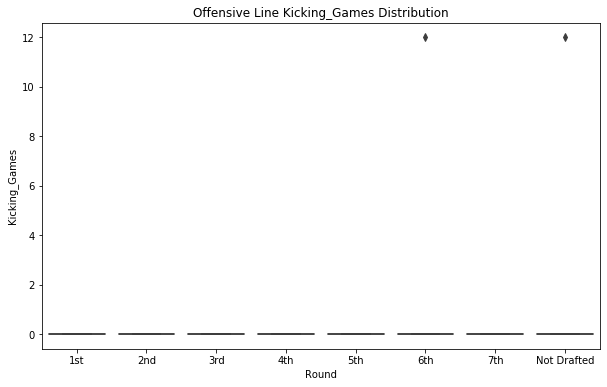

Offensive Line XP_Made Summary:
count   562.00
mean      0.12
std       2.07
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      39.00
Name: XP_Made, dtype: float64
----------------------------------------
Offensive Line XP_Made by Round
             XP_Made
Round               
1st             0.00
2nd             0.00
3rd             0.00
4th             0.00
5th             0.00
6th             0.70
7th             0.00
Not Drafted     0.31


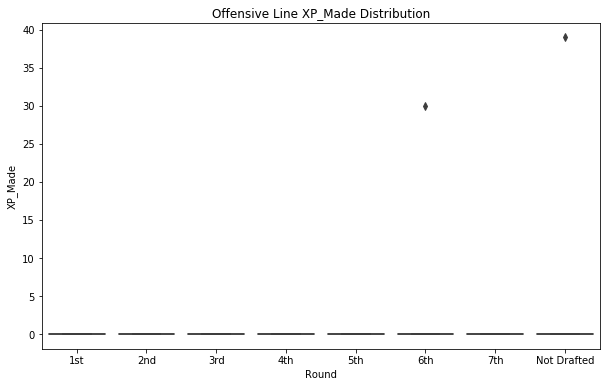

Offensive Line XP_Attempts Summary:
count   562.00
mean      0.12
std       2.10
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      39.00
Name: XP_Attempts, dtype: float64
----------------------------------------
Offensive Line XP_Attempts by Round
             XP_Attempts
Round                   
1st                 0.00
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.00
6th                 0.72
7th                 0.00
Not Drafted         0.31


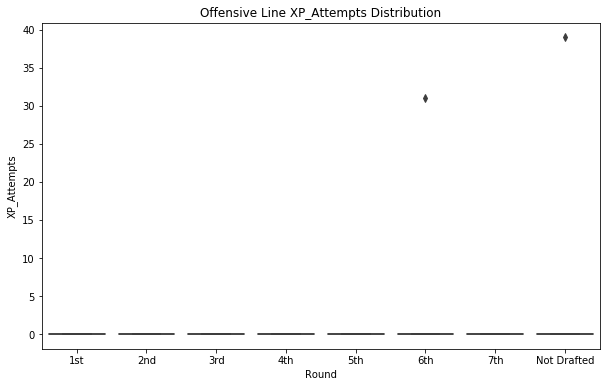

Offensive Line XP_Percent Summary:
count   562.00
mean      0.35
std       5.87
min       0.00
25%       0.00
50%       0.00
75%       0.00
max     100.00
Name: XP_Percent, dtype: float64
----------------------------------------
Offensive Line XP_Percent by Round
             XP_Percent
Round                  
1st                0.00
2nd                0.00
3rd                0.00
4th                0.00
5th                0.00
6th                2.25
7th                0.00
Not Drafted        0.79


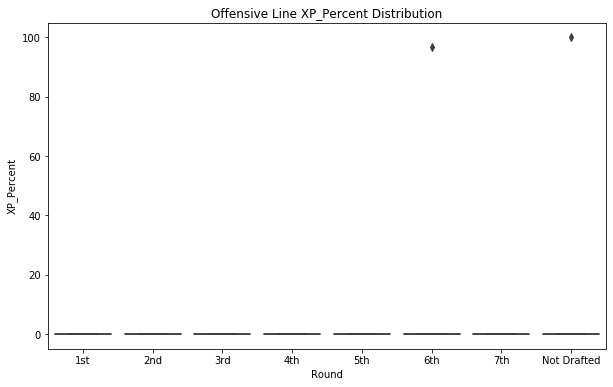

Offensive Line FG_Made Summary:
count   562.00
mean      0.08
std       1.36
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      29.00
Name: FG_Made, dtype: float64
----------------------------------------
Offensive Line FG_Made by Round
             FG_Made
Round               
1st             0.00
2nd             0.00
3rd             0.00
4th             0.00
5th             0.00
6th             0.67
7th             0.00
Not Drafted     0.11


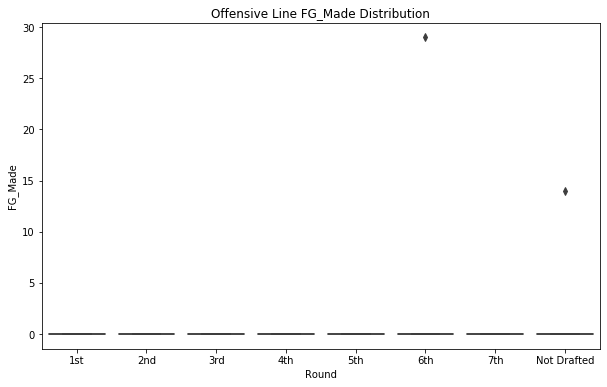

Offensive Line FG_Attempts Summary:
count   562.00
mean      0.10
std       1.79
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      35.00
Name: FG_Attempts, dtype: float64
----------------------------------------
Offensive Line FG_Attempts by Round
             FG_Attempts
Round                   
1st                 0.00
2nd                 0.00
3rd                 0.00
4th                 0.00
5th                 0.00
6th                 0.81
7th                 0.00
Not Drafted         0.19


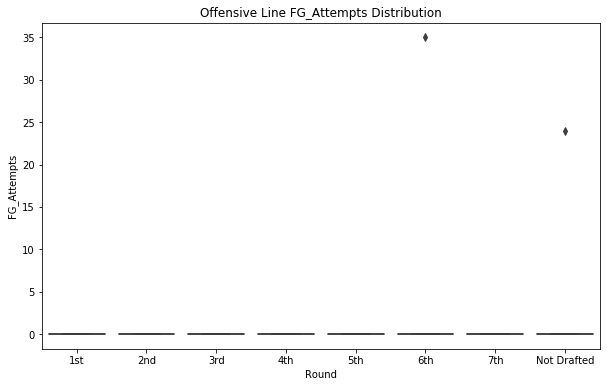

Offensive Line FG_Percent Summary:
count   562.00
mean      0.25
std       4.27
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      82.90
Name: FG_Percent, dtype: float64
----------------------------------------
Offensive Line FG_Percent by Round
             FG_Percent
Round                  
1st                0.00
2nd                0.00
3rd                0.00
4th                0.00
5th                0.00
6th                1.93
7th                0.00
Not Drafted        0.46


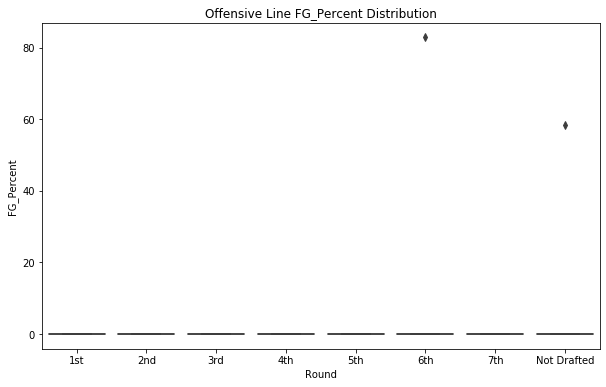

Offensive Line TTL_Kicking_Points Summary:
count   562.00
mean      0.35
std       6.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max     117.00
Name: TTL_Kicking_Points, dtype: float64
----------------------------------------
Offensive Line TTL_Kicking_Points by Round
             TTL_Kicking_Points
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        2.72
7th                        0.00
Not Drafted                0.64


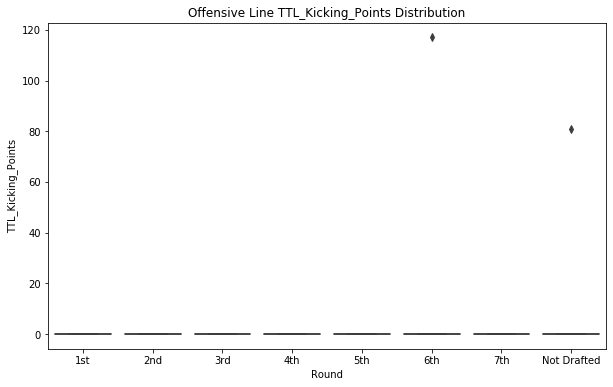

Offensive Line NumPunts Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: NumPunts, dtype: float64
----------------------------------------
Offensive Line NumPunts by Round
             NumPunts
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.00


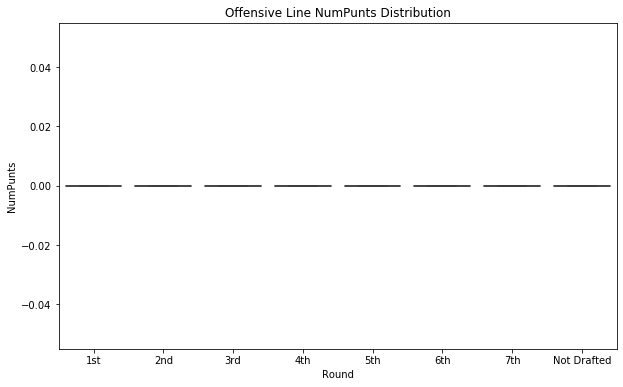

Offensive Line Punt_Yds Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Punt_Yds, dtype: float64
----------------------------------------
Offensive Line Punt_Yds by Round
             Punt_Yds
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.00


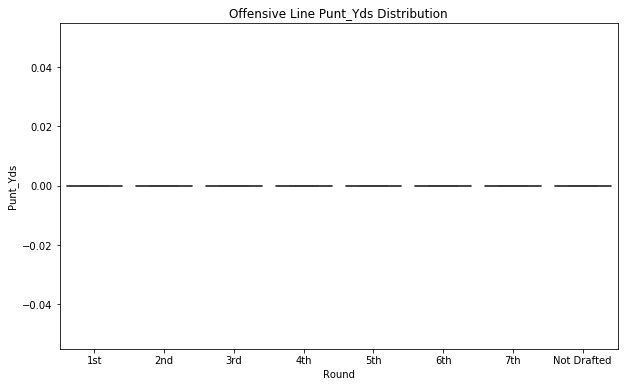

Offensive Line Yds_per_Punt Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Yds_per_Punt, dtype: float64
----------------------------------------
Offensive Line Yds_per_Punt by Round
             Yds_per_Punt
Round                    
1st                  0.00
2nd                  0.00
3rd                  0.00
4th                  0.00
5th                  0.00
6th                  0.00
7th                  0.00
Not Drafted          0.00


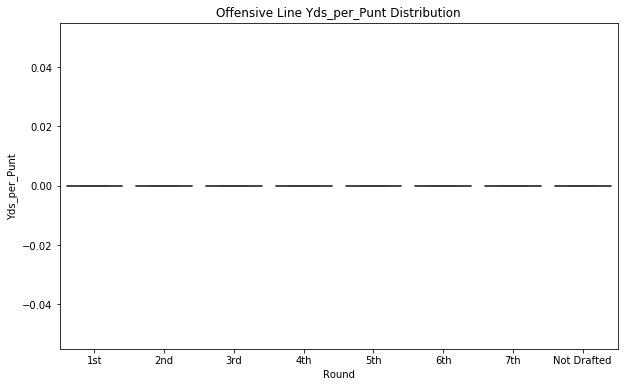

Offensive Line XP_MadeperGame Summary:
count   562.00
mean      0.01
std       0.17
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       3.25
Name: XP_MadeperGame, dtype: float64
----------------------------------------
Offensive Line XP_MadeperGame by Round
             XP_MadeperGame
Round                      
1st                    0.00
2nd                    0.00
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.06
7th                    0.00
Not Drafted            0.03


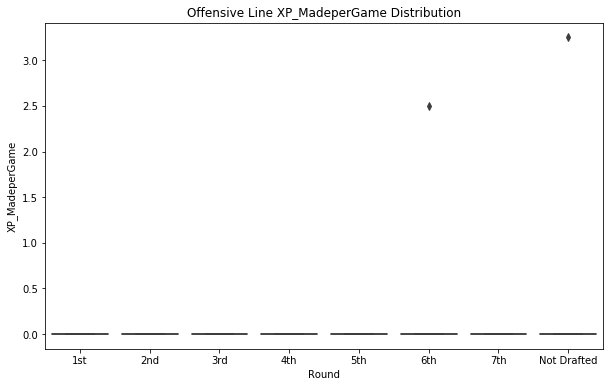

Offensive Line XP_AttemptsperGame Summary:
count   562.00
mean      0.01
std       0.17
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       3.25
Name: XP_AttemptsperGame, dtype: float64
----------------------------------------
Offensive Line XP_AttemptsperGame by Round
             XP_AttemptsperGame
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.06
7th                        0.00
Not Drafted                0.03


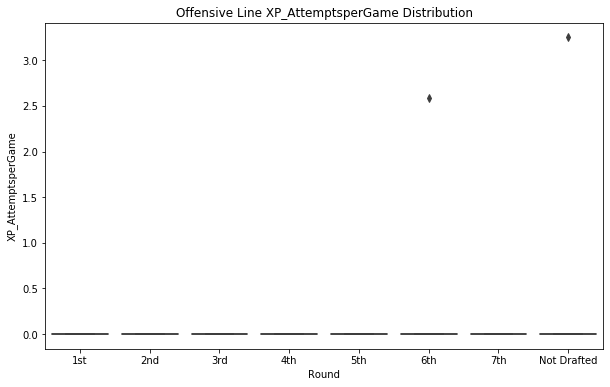

Offensive Line FG_MadeperGame Summary:
count   562.00
mean      0.01
std       0.11
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       2.42
Name: FG_MadeperGame, dtype: float64
----------------------------------------
Offensive Line FG_MadeperGame by Round
             FG_MadeperGame
Round                      
1st                    0.00
2nd                    0.00
3rd                    0.00
4th                    0.00
5th                    0.00
6th                    0.06
7th                    0.00
Not Drafted            0.01


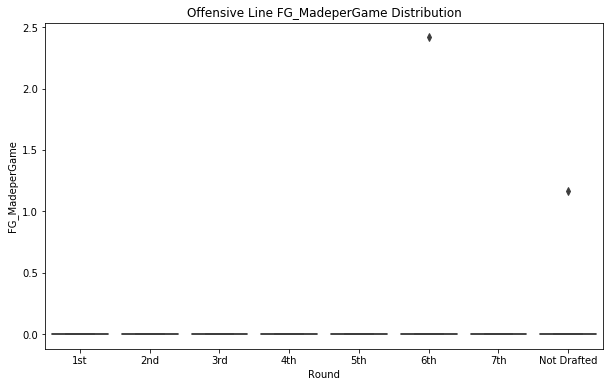

Offensive Line FG_AttemptsperGame Summary:
count   562.00
mean      0.01
std       0.15
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       2.92
Name: FG_AttemptsperGame, dtype: float64
----------------------------------------
Offensive Line FG_AttemptsperGame by Round
             FG_AttemptsperGame
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.07
7th                        0.00
Not Drafted                0.02


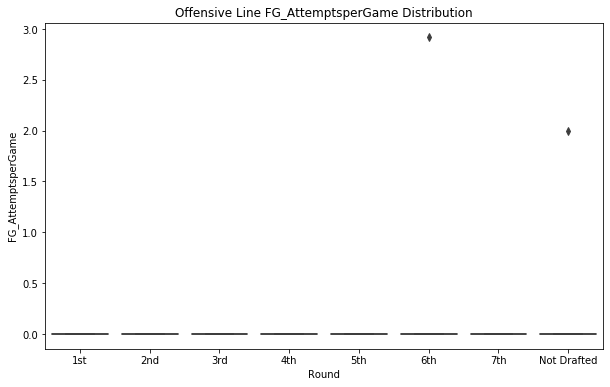

Offensive Line TTL_Kicking_PointsperGame Summary:
count   562.00
mean      0.03
std       0.50
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       9.75
Name: TTL_Kicking_PointsperGame, dtype: float64
----------------------------------------
Offensive Line TTL_Kicking_PointsperGame by Round
             TTL_Kicking_PointsperGame
Round                                 
1st                               0.00
2nd                               0.00
3rd                               0.00
4th                               0.00
5th                               0.00
6th                               0.23
7th                               0.00
Not Drafted                       0.05


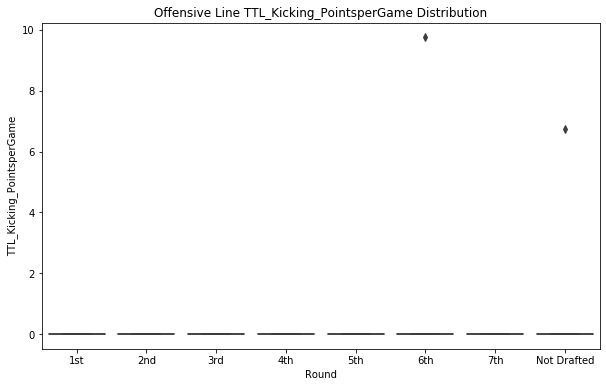

Offensive Line NumPuntsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: NumPuntsperGame, dtype: float64
----------------------------------------
Offensive Line NumPuntsperGame by Round
             NumPuntsperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


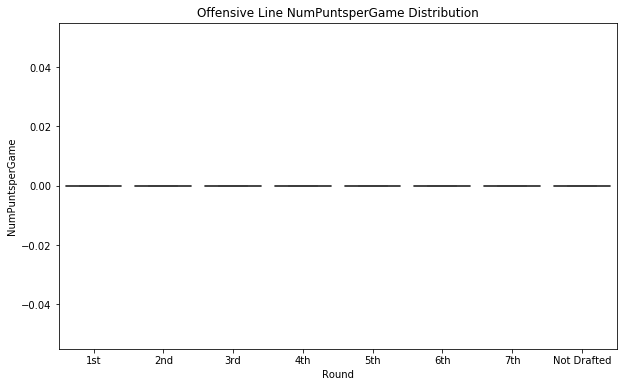

Offensive Line Punt_YdsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Punt_YdsperGame, dtype: float64
----------------------------------------
Offensive Line Punt_YdsperGame by Round
             Punt_YdsperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


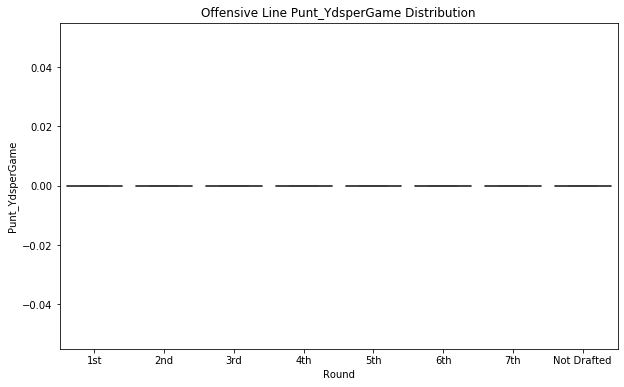

In [36]:
plot_stats('Offensive Line', df, kicking_stats)

In [38]:
for i in kicking_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Offensive Line', df, i)
    print('')
    print('*' * 40)

Kicking_Games ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00    3.46     0.49 0.97    0.46
Residual 554.00  283.52     0.51  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd      0.0    0.9 -0.3543 0.3543  False
   1st         3rd      0.0    0.9 -0.3403 0.3403  False
   1st         4th      0.0    0.9 -0.3497 0.3497  False
   1st         5th      0.0    0.9 -0.3704 0.3704  False
   1st         6th   0.2791 0.4159 -0.1244 0.6826  False
   1st         7th      0.0    0.9 -0.4211 0.4211  False
   1st Not Drafted   0.0945    0.9 -0.2054 0.3944  False
   2nd         3rd      0.0    0.9 -0.3688 0.3688  False
   2nd         4th      0.0    0.9 -0.3776 0.3776  False
   2nd         5th      0.0    0.9 -0.3968 0.3968  False
   2nd         6th   0.2791 0.4935 -0.1488 0.7069  Fa

             df   sum_sq  mean_sq    F  PR(>F)
Round      7.00   300.25    42.89 1.20    0.30
Residual 554.00 19879.99    35.88  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd      0.0    0.9 -2.9667 2.9667  False
   1st         3rd      0.0    0.9 -2.8495 2.8495  False
   1st         4th      0.0    0.9 -2.9285 2.9285  False
   1st         5th      0.0    0.9  -3.102  3.102  False
   1st         6th   2.7209 0.2196 -0.6578 6.0997  False
   1st         7th      0.0    0.9  -3.526  3.526  False
   1st Not Drafted   0.6378    0.9 -1.8735 3.1491  False
   2nd         3rd      0.0    0.9 -3.0886 3.0886  False
   2nd         4th      0.0    0.9 -3.1616 3.1616  False
   2nd         5th      0.0    0.9  -3.323  3.323  False
   2nd         6th   2.7209 0.2897 -0.8617 6.3036  False
   2nd         7th      0.0    0.9 -3.7218 3.7218  False
   


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.0 0.5566   0.0   0.0  False
   1st         6th      0.0 0.5566   0.0   0.0  False
   1st         7th      0.0 0.5566   0.0   0.0  False
   1st Not Drafted      0.0 0.5566   0.0   0.0  False
   2nd         3rd      0.0 0.5566   0.0   0.0  False
   2nd         4th      0.0 0.5566   0.0   0.0  False
   2nd         5th      0.0 0.5566   0.0   0.0  False
   2nd         6th      0.0 0.5566   0.0   0.0  False
   2nd         7th      0.0 0.5566   0.0   0


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.

### College Stats - Punt Returns

In [39]:
puntret_stats = ['PuntRet_Games', 'Kickoff_Returns', 'KO_Return_Yds', 'Yds_per_KO_Return', 'KO_Returned_for_TD', 
                 'Kickoff_ReturnsperGame', 'KO_Return_YdsperGame', 'KO_Returned_for_TDperGame']

In [40]:
df[puntret_stats].describe()

,PuntRet_Games,Kickoff_Returns,KO_Return_Yds,Yds_per_KO_Return,KO_Returned_for_TD,Kickoff_ReturnsperGame,KO_Return_YdsperGame,KO_Returned_for_TDperGame
count,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00
mean,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Offensive Line PuntRet_Games Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: PuntRet_Games, dtype: float64
----------------------------------------
Offensive Line PuntRet_Games by Round
             PuntRet_Games
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


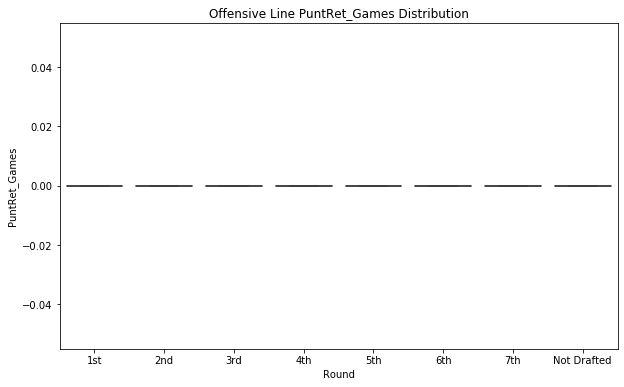

Offensive Line Kickoff_Returns Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Kickoff_Returns, dtype: float64
----------------------------------------
Offensive Line Kickoff_Returns by Round
             Kickoff_Returns
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


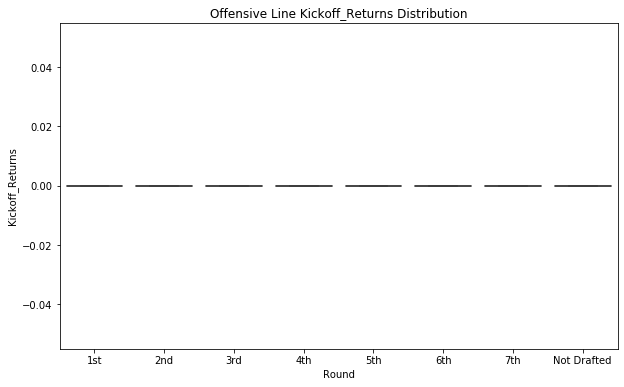

Offensive Line KO_Return_Yds Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: KO_Return_Yds, dtype: float64
----------------------------------------
Offensive Line KO_Return_Yds by Round
             KO_Return_Yds
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


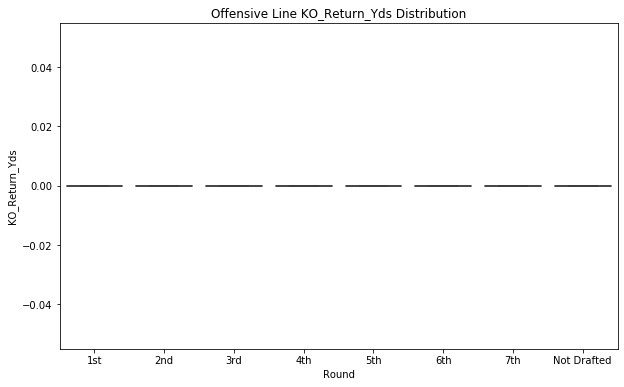

Offensive Line Yds_per_KO_Return Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Yds_per_KO_Return, dtype: float64
----------------------------------------
Offensive Line Yds_per_KO_Return by Round
             Yds_per_KO_Return
Round                         
1st                       0.00
2nd                       0.00
3rd                       0.00
4th                       0.00
5th                       0.00
6th                       0.00
7th                       0.00
Not Drafted               0.00


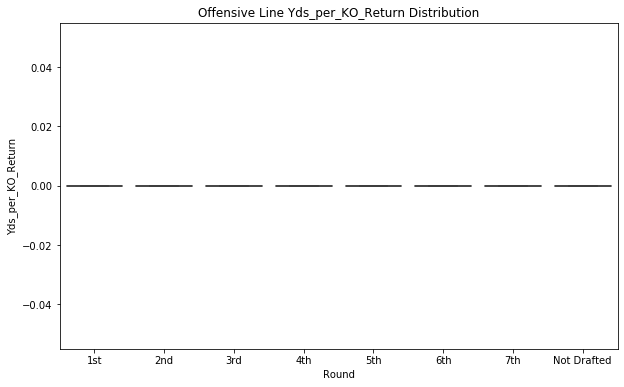

Offensive Line KO_Returned_for_TD Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: KO_Returned_for_TD, dtype: float64
----------------------------------------
Offensive Line KO_Returned_for_TD by Round
             KO_Returned_for_TD
Round                          
1st                        0.00
2nd                        0.00
3rd                        0.00
4th                        0.00
5th                        0.00
6th                        0.00
7th                        0.00
Not Drafted                0.00


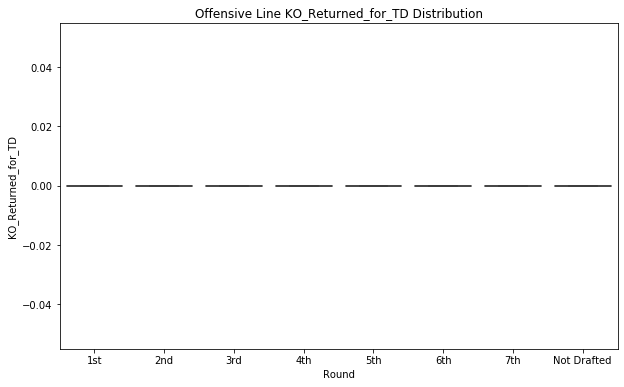

Offensive Line Kickoff_ReturnsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Kickoff_ReturnsperGame, dtype: float64
----------------------------------------
Offensive Line Kickoff_ReturnsperGame by Round
             Kickoff_ReturnsperGame
Round                              
1st                            0.00
2nd                            0.00
3rd                            0.00
4th                            0.00
5th                            0.00
6th                            0.00
7th                            0.00
Not Drafted                    0.00


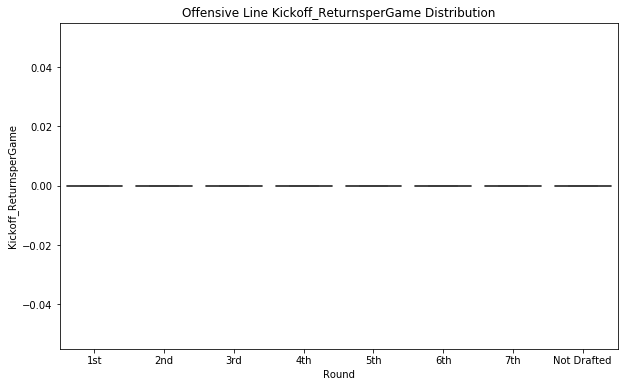

Offensive Line KO_Return_YdsperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: KO_Return_YdsperGame, dtype: float64
----------------------------------------
Offensive Line KO_Return_YdsperGame by Round
             KO_Return_YdsperGame
Round                            
1st                          0.00
2nd                          0.00
3rd                          0.00
4th                          0.00
5th                          0.00
6th                          0.00
7th                          0.00
Not Drafted                  0.00


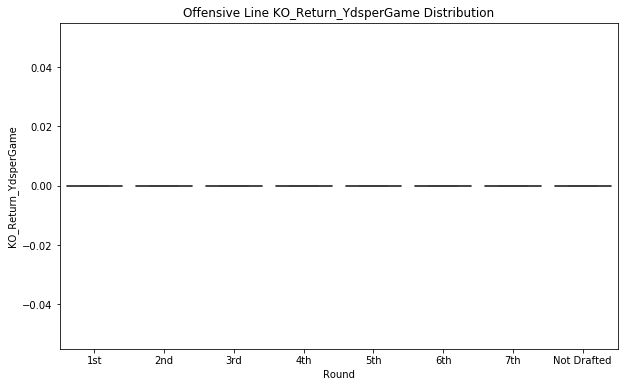

Offensive Line KO_Returned_for_TDperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: KO_Returned_for_TDperGame, dtype: float64
----------------------------------------
Offensive Line KO_Returned_for_TDperGame by Round
             KO_Returned_for_TDperGame
Round                                 
1st                               0.00
2nd                               0.00
3rd                               0.00
4th                               0.00
5th                               0.00
6th                               0.00
7th                               0.00
Not Drafted                       0.00


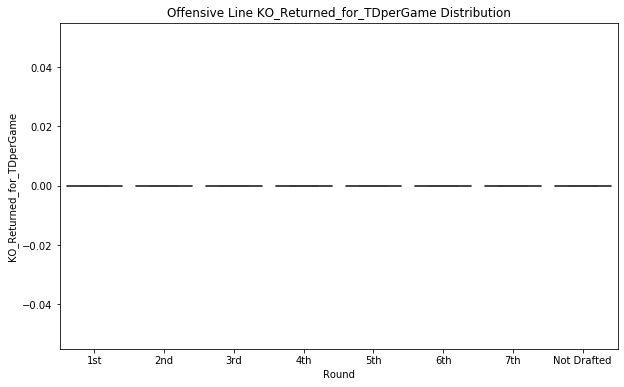

In [41]:
plot_stats('Offensive Line', df, puntret_stats)

In [42]:
for i in puntret_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Receivers', receivers_df, i)
    print('')
    print('*' * 40)

PuntRet_Games ANOVA Test:
----------------------------------------
              df   sum_sq  mean_sq    F  PR(>F)
Round       7.00   261.28    37.33 1.74    0.10
Residual 1804.00 38749.55    21.48  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.5522    0.9 -2.1082 1.0037  False
   1st         3rd  -0.9653 0.5367 -2.4975 0.5669  False
   1st         4th  -0.3973    0.9 -1.9034 1.1088  False
   1st         5th  -0.4513    0.9 -2.0514 1.1488  False
   1st         6th  -1.2028 0.3363  -2.842 0.4364  False
   1st         7th  -1.2651 0.2313 -2.8503 0.3201  False
   1st Not Drafted  -1.0436  0.192 -2.3059 0.2187  False
   2nd         3rd  -0.4131    0.9 -1.8963 1.0702  False
   2nd         4th   0.1549    0.9 -1.3013 1.6112  False
   2nd         5th   0.1009    0.9 -1.4524 1.6542  False
   2nd         6th  -0.6505    0.9 -2.2441  0.9

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd  -0.0065    0.9 -0.0314 0.0184  False
   1st         3rd   0.0096    0.9 -0.0149 0.0342  False
   1st         4th  -0.0015    0.9 -0.0256 0.0226  False
   1st         5th  -0.0065    0.9 -0.0321 0.0191  False
   1st         6th   0.0006    0.9 -0.0256 0.0268  False
   1st         7th  -0.0003    0.9 -0.0257 0.0251  False
   1st Not Drafted  -0.0049    0.9 -0.0251 0.0153  False
   2nd         3rd   0.0161 0.4431 -0.0076 0.0399  False
   2nd         4th    0.005    0.9 -0.0183 0.0283  False
   2nd         5th      0.0    0.9 -0.0249 0.0249  False
   2nd         6th   0.0071    0.9 -0.0184 0.0326  False
   2nd         7th   0.0062    0.9 -0.0184 0.0308  False
   2nd Not Drafted   0.0016    0.9 -0.0177 0.0208  False
   3rd         4th  -0.0112 0.7957 -0.0341 0.0117  False
   3rd         5th  -0.0161 0.4

### College Stats - Scoring

In [42]:
scoring_stats = ['Scoring_Games', 'TD_Other', 'Ttl_TDs', 'TwoPT_Conversion', 'Safety', 'TTL_Points', 'TD_OtherperGame',
                 'Ttl_TDsperGame', 'TwoPT_ConversionperGame', 'SafetyperGame', 'TTL_PointsperGame']

In [43]:
df[scoring_stats].describe()

,Scoring_Games,TD_Other,Ttl_TDs,TwoPT_Conversion,Safety,TTL_Points,TD_OtherperGame,Ttl_TDsperGame,TwoPT_ConversionperGame,SafetyperGame,TTL_PointsperGame
count,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00,562.00
mean,0.60,0.00,0.06,0.00,0.00,0.83,0.00,0.02,0.00,0.00,0.14
std,2.57,0.00,0.37,0.00,0.00,6.79,0.00,0.11,0.00,0.00,0.85
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,14.00,0.00,6.00,0.00,0.00,117.00,0.00,1.00,0.00,0.00,9.75


Offensive Line Scoring_Games Summary:
count   562.00
mean      0.60
std       2.57
min       0.00
25%       0.00
50%       0.00
75%       0.00
max      14.00
Name: Scoring_Games, dtype: float64
----------------------------------------
Offensive Line Scoring_Games by Round
             Scoring_Games
Round                     
1st                   0.71
2nd                   0.77
3rd                   0.35
4th                   0.72
5th                   0.82
6th                   0.53
7th                   0.00
Not Drafted           0.64


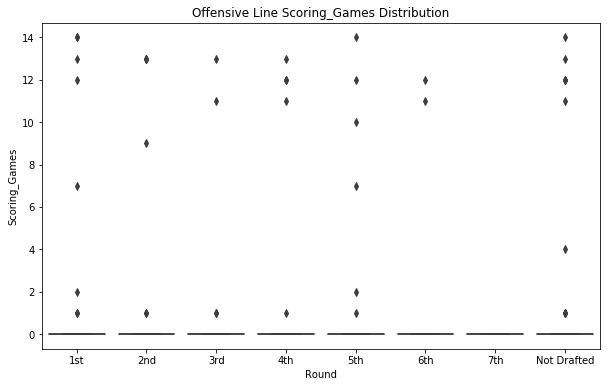

Offensive Line TD_Other Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: TD_Other, dtype: float64
----------------------------------------
Offensive Line TD_Other by Round
             TD_Other
Round                
1st              0.00
2nd              0.00
3rd              0.00
4th              0.00
5th              0.00
6th              0.00
7th              0.00
Not Drafted      0.00


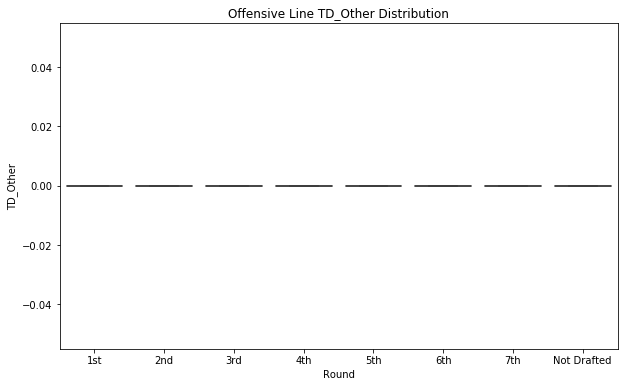

Offensive Line Ttl_TDs Summary:
count   562.00
mean      0.06
std       0.37
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       6.00
Name: Ttl_TDs, dtype: float64
----------------------------------------
Offensive Line Ttl_TDs by Round
             Ttl_TDs
Round               
1st             0.07
2nd             0.09
3rd             0.03
4th             0.04
5th             0.07
6th             0.02
7th             0.00
Not Drafted     0.10


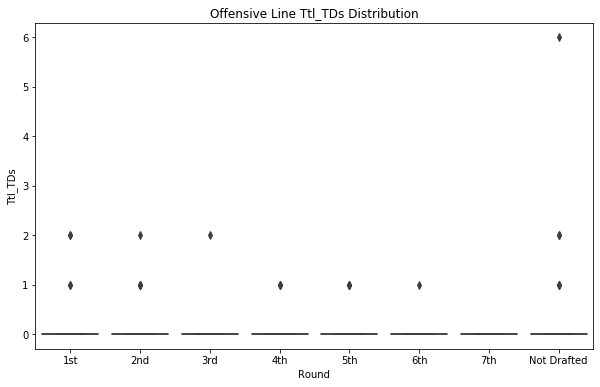

Offensive Line TwoPT_Conversion Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: TwoPT_Conversion, dtype: float64
----------------------------------------
Offensive Line TwoPT_Conversion by Round
             TwoPT_Conversion
Round                        
1st                      0.00
2nd                      0.00
3rd                      0.00
4th                      0.00
5th                      0.00
6th                      0.00
7th                      0.00
Not Drafted              0.00


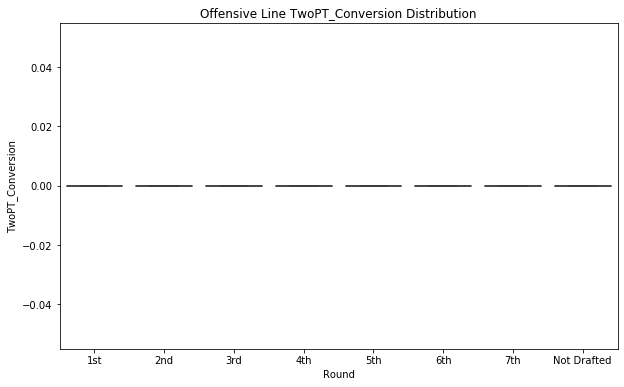

Offensive Line Safety Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: Safety, dtype: float64
----------------------------------------
Offensive Line Safety by Round
             Safety
Round              
1st            0.00
2nd            0.00
3rd            0.00
4th            0.00
5th            0.00
6th            0.00
7th            0.00
Not Drafted    0.00


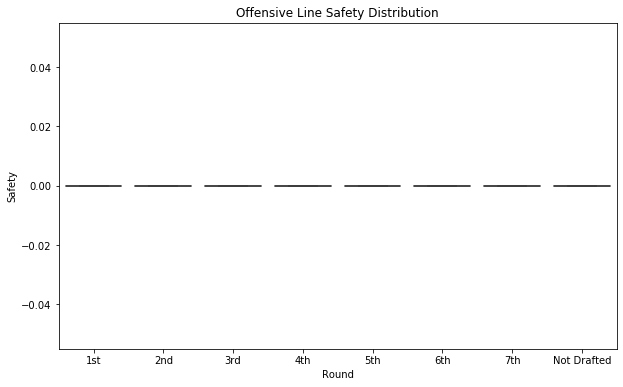

Offensive Line TTL_Points Summary:
count   562.00
mean      0.83
std       6.79
min       0.00
25%       0.00
50%       0.00
75%       0.00
max     117.00
Name: TTL_Points, dtype: float64
----------------------------------------
Offensive Line TTL_Points by Round
             TTL_Points
Round                  
1st                0.40
2nd                0.55
3rd                0.16
4th                0.26
5th                0.43
6th                2.86
7th                0.00
Not Drafted        1.70


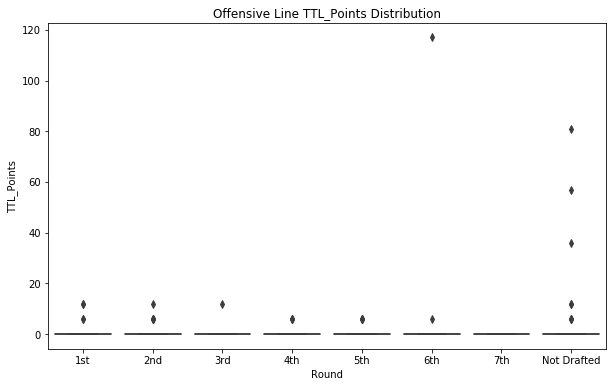

Offensive Line TD_OtherperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: TD_OtherperGame, dtype: float64
----------------------------------------
Offensive Line TD_OtherperGame by Round
             TD_OtherperGame
Round                       
1st                     0.00
2nd                     0.00
3rd                     0.00
4th                     0.00
5th                     0.00
6th                     0.00
7th                     0.00
Not Drafted             0.00


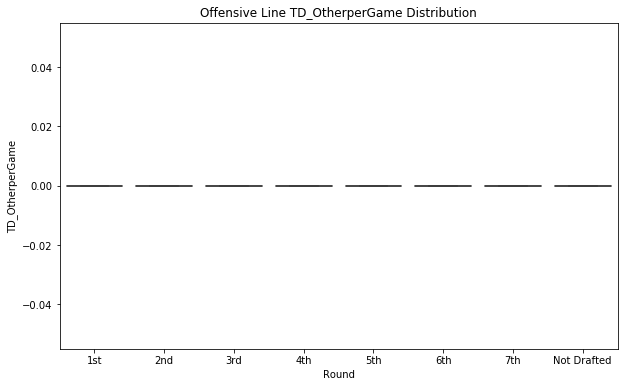

Offensive Line Ttl_TDsperGame Summary:
count   562.00
mean      0.02
std       0.11
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       1.00
Name: Ttl_TDsperGame, dtype: float64
----------------------------------------
Offensive Line Ttl_TDsperGame by Round
             Ttl_TDsperGame
Round                      
1st                    0.02
2nd                    0.02
3rd                    0.00
4th                    0.02
5th                    0.03
6th                    0.00
7th                    0.00
Not Drafted            0.02


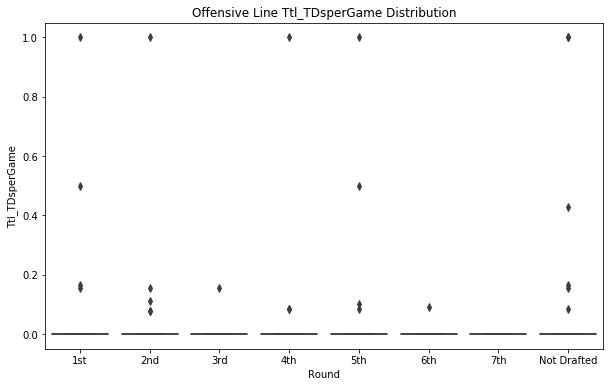

Offensive Line TwoPT_ConversionperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: TwoPT_ConversionperGame, dtype: float64
----------------------------------------
Offensive Line TwoPT_ConversionperGame by Round
             TwoPT_ConversionperGame
Round                               
1st                             0.00
2nd                             0.00
3rd                             0.00
4th                             0.00
5th                             0.00
6th                             0.00
7th                             0.00
Not Drafted                     0.00


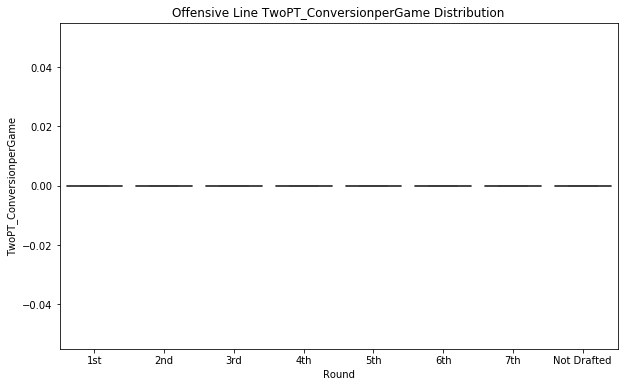

Offensive Line SafetyperGame Summary:
count   562.00
mean      0.00
std       0.00
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       0.00
Name: SafetyperGame, dtype: float64
----------------------------------------
Offensive Line SafetyperGame by Round
             SafetyperGame
Round                     
1st                   0.00
2nd                   0.00
3rd                   0.00
4th                   0.00
5th                   0.00
6th                   0.00
7th                   0.00
Not Drafted           0.00


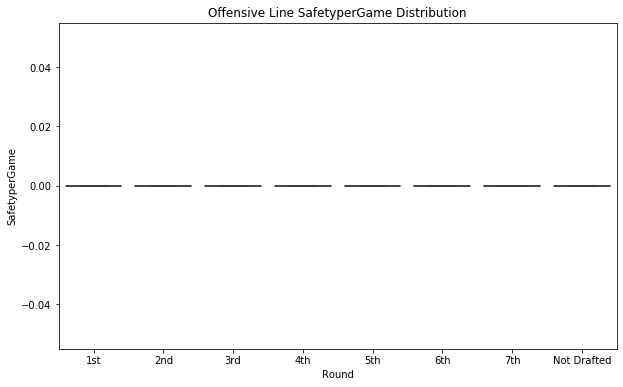

Offensive Line TTL_PointsperGame Summary:
count   562.00
mean      0.14
std       0.85
min       0.00
25%       0.00
50%       0.00
75%       0.00
max       9.75
Name: TTL_PointsperGame, dtype: float64
----------------------------------------
Offensive Line TTL_PointsperGame by Round
             TTL_PointsperGame
Round                         
1st                       0.12
2nd                       0.13
3rd                       0.01
4th                       0.10
5th                       0.18
6th                       0.24
7th                       0.00
Not Drafted               0.23


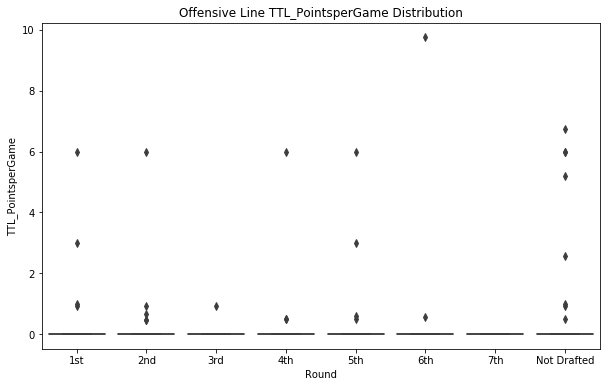

In [44]:
plot_stats('Offensive Line', df, scoring_stats)

In [45]:
for i in scoring_stats:
    print(i + ' ANOVA Test:')
    print('-' * 40)
    anova_tukey('Offensive Line', df, i)
    print('')
    print('*' * 40)

Scoring_Games ANOVA Test:
----------------------------------------
             df  sum_sq  mean_sq    F  PR(>F)
Round      7.00   25.56     3.65 0.55    0.80
Residual 554.00 3686.96     6.66  nan     nan

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1    group2   meandiff p-adj   lower  upper  reject
--------------------------------------------------------
   1st         2nd   0.0581    0.9 -1.2195 1.3357  False
   1st         3rd  -0.3644    0.9 -1.5916 0.8627  False
   1st         4th   0.0095    0.9 -1.2517 1.2706  False
   1st         5th   0.1103    0.9 -1.2256 1.4462  False
   1st         6th  -0.1762    0.9 -1.6313 1.2788  False
   1st         7th  -0.7111  0.827 -2.2296 0.8073  False
   1st Not Drafted  -0.0733    0.9 -1.1548 1.0082  False
   2nd         3rd  -0.4226    0.9 -1.7527 0.9075  False
   2nd         4th  -0.0486    0.9 -1.4102 1.3129  False
   2nd         5th   0.0522    0.9 -1.3788 1.4832  False
   2nd         6th  -0.2343    0.9 -1.7772 1.3085  Fa


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.0 0.5566   0.0   0.0  Fal


NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1    group2   meandiff p-adj  lower upper reject
-----------------------------------------------------
   1st         2nd      0.0 0.5566   0.0   0.0  False
   1st         3rd      0.0 0.5566   0.0   0.0  False
   1st         4th      0.0 0.5566   0.0   0.0  False
   1st         5th      0.